# Исследование свойст характеристики

## Подготовим вспомогательные инструменты для дальнейших исследований

In [2]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import networkx as nx

Генерация случайных величин, которые имеют распределение $Exp(λ)$ и $LogNormal(0, σ)$

In [128]:
def generate_exp(n, lam):
  return np.random.exponential(scale=1 / lam, size=n)

def generate_lognormal(n, sigma):
  return np.random.lognormal(mean=0, sigma=sigma, size=n)

**Построение KNN-графа** \
Построим KNN-граф на нашей случайной выборке $\Xi$

In [6]:
def build_knn_graph(k, vertices):
    v = np.asarray(vertices, dtype=float).reshape(-1, 1)
    n = v.shape[0]

    nbrs = NearestNeighbors(n_neighbors=k+1).fit(v)
    distances, indices = nbrs.kneighbors(v)

    G = nx.Graph()
    G.add_nodes_from(range(n))

    for i in range(n):
        for j in indices[i][1:]:
            G.add_edge(i, j)

    return G

Фукнция, которая вычисялет минимальную степень вершины в графе

In [7]:
def min_degree(G: nx.Graph) -> int:
    return min(deg for _, deg in G.degree())

Фукнция, которая вычисялет кол-во компонент треугольников в графе

In [164]:
def num_triangles(G: nx.Graph) -> int:
    return sum(dict(nx.triangles(G)).values()) // 3

**Построение дистанционного графа** \
Построим дистанционный граф на нашей случайной выборке $\Xi$

In [8]:

def build_distance_graph(d, vertices):
    v = np.asarray(vertices)
    n = v.size

    G = nx.Graph()
    G.add_nodes_from(range(n))

    for i in range(n):
        for j in range(i+1, n):
            if abs(v[i] - v[j]) <= d:
                G.add_edge(i, j)

    return G

Фукнция, которая вычисялет кликовое число в графе

In [9]:
def get_clique_number(G: nx.Graph) -> int:
    return max((len(clique) for clique in nx.find_cliques(G)), default=0)

**метод Монте-Карло**

In [10]:
def monte_carlo(M, n, distr_param, graph_param, gen_func, graph_func, res_func):
  """
  Функция для реализации метода Монте-Карло.
  M - кол-во исследований.
  n - кол-во вершин в графе.
  distr_param - distribution parameter, параметр распределения.
  graph_param - параметр графа, то есть k - для KNN-графа или d - для дистанционного графа.
  gen_func - функция для генерации реализации распределения: genrate_lognormal или genrate_exp.
  graph_func - функция для построения графа: build_knn_graph или build_distance_graph.
  res_func - функция для вычисления характеристики графа: min_degree или get_clique_number.
  """
  results = []
  for _ in range(M):
    vertices = gen_func(n, distr_param)
    G = graph_func(graph_param, vertices)
    results.append(res_func(G))
  return results

In [123]:
from joblib import Parallel, delayed

def monte_carlo_step(n, distr_param, graph_param, gen_func, graph_func, res_func):
    vertices = gen_func(n, distr_param)
    G = graph_func(graph_param, vertices)
    return res_func(G)

def monte_carlo_multiprocessing(M, n, distr_param, graph_param, gen_func, graph_func, res_func):
  """
  Функция для реализации метода Монте-Карло с параллельными вычислениями.
  M - кол-во исследований.
  n - кол-во вершин в графе.
  distr_param - distribution parameter, параметр распределения.
  graph_param - параметр графа, то есть k - для KNN-графа или d - для дистанционного графа.
  gen_func - функция для генерации реализации распределения: genrate_lognormal или genrate_exp.
  graph_func - функция для построения графа: build_knn_graph или build_distance_graph.
  res_func - функция для вычисления характеристики графа: min_degree или get_clique_number.
  """
  results = Parallel(n_jobs=-1)(delayed(monte_carlo_step)(n, distr_param, graph_param, gen_func, graph_func, res_func) for _ in range(M))
  return results

Функция для вычисления базовых статистических метрик: среднее значение, дисперсия, стандартное отклонение, стандартная ошибка среднего.

In [11]:
import math

def compute_stats(arr):
    mean = np.mean(arr)
    var = np.var(arr, ddof=1)
    std = math.sqrt(var)
    se = std / math.sqrt(len(arr))
    return mean, var, std, se

Функция для анализа результатов и построения гистограммы.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [53]:
def analyze(n, graph_param, exp_results, lognormal_results, need_hist=True):
    mean_exp, var_exp, std_exp, se_exp = compute_stats(exp_results)
    mean_log, var_log, std_log, se_log = compute_stats(lognormal_results)
    p95_exp = np.percentile(exp_results, 95)
    threshold = (mean_exp + mean_log) / 2

    alpha = np.mean(exp_results > p95_exp)
    power = np.mean(lognormal_results > p95_exp)


    metrics = {
        'n': n, 'graph_param': graph_param,
        'power': power,
        'alpha': alpha,
        'p95_exp': p95_exp,
        'threshold': threshold,
        'mean_exp': mean_exp, 'var_exp': var_exp, 'std_exp': std_exp, 'se_exp': se_exp,
        'mean_log': mean_log, 'var_log': var_log, 'std_log': std_log, 'se_log': se_log,
    }

    if not need_hist:
        return metrics

    fig, ax = plt.subplots(figsize=(8, 5))
    bins = 'auto'

    ax.hist(exp_results, bins=bins, alpha=0.6, label='exp_results', density=True)
    ax.hist(lognormal_results, bins=bins, alpha=0.6, label='lognormal_results', density=True)

    ax.axvline(p95_exp, color='red', linestyle='--',
                label=f'95% exp ({p95_exp:.2f})')
    
    ax.axvline(threshold, color='darkblue', alpha=0.5, linestyle=':',
                label=f'threshold ({threshold:.2f})')

    ax.set_title(f'Гистограмма для n={n}, параметр графа={graph_param}\nМощность={power}, ошибка первого рода={alpha}')
    ax.set_xlabel('Значение характеристики')
    ax.set_ylabel('Плотность (frequency density)')
    ax.legend()
    plt.tight_layout()
    plt.show()

    return metrics

## Исследуем, как ведет себя $Τ$ в зависимости от параметров процедуры построения графа и размера выборки

Зафиксируем параметры распределения: 
* $Exp(λ)$, $\; λ_0 = \frac{1}{\sqrt{e^2 - e}}$
* $LogNormal(0, \sigma)$, $\; \sigma_0 = 1$

In [12]:
import math

lam0 = 1/(math.sqrt(math.e**2 - math.e))
sigma0 = 1

#### Исследуем дистанционный-граф

In [131]:
M = 500
n_array = [25, 100, 500, 1000]
d_array = [
    [0.2, 0.4, 0.6],
    [0.1, 0.2, 0.3],
    [0.05, 0.1, 0.15],
    [0.01, 0.05, 0.1]
]

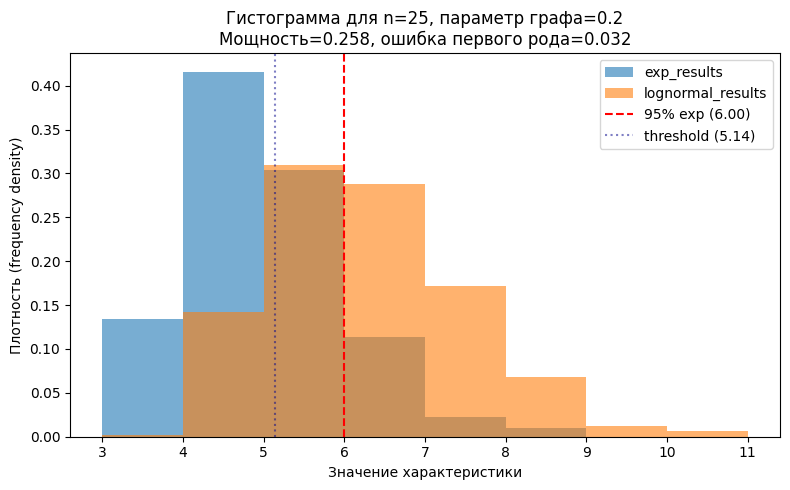

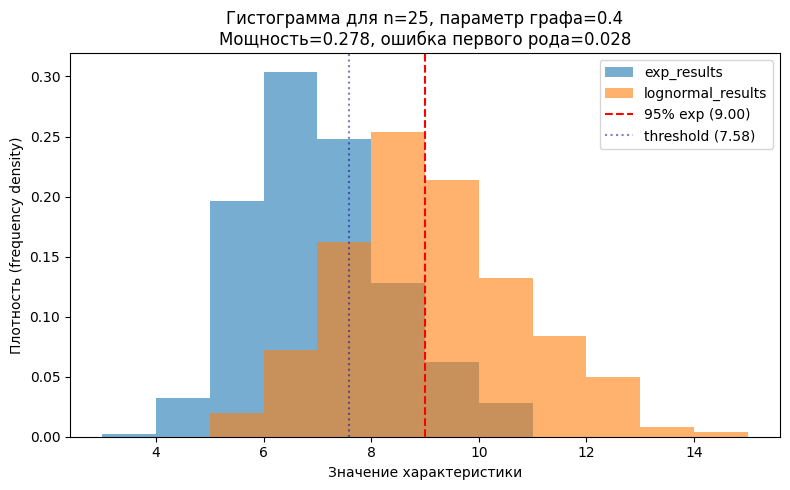

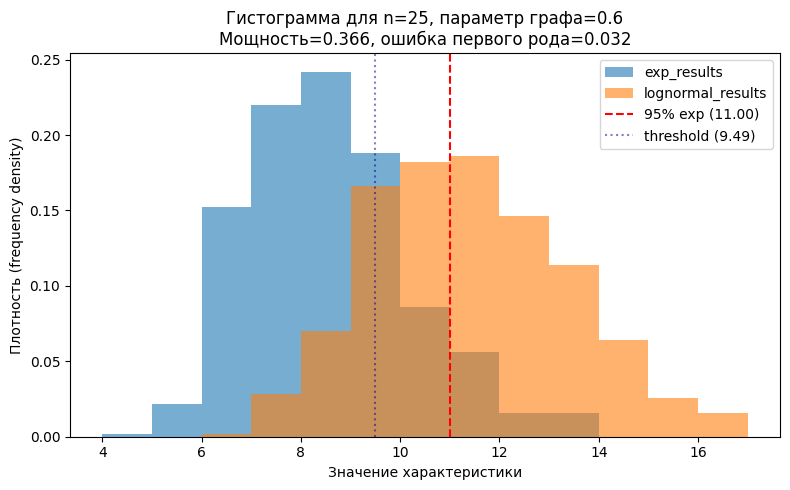

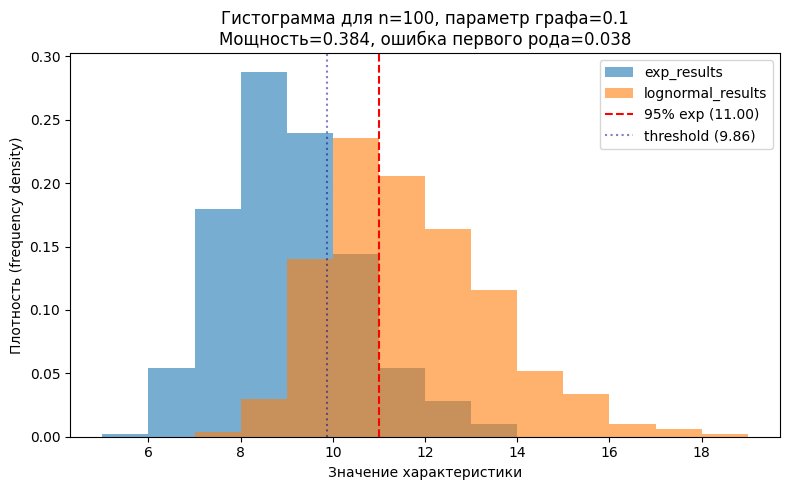

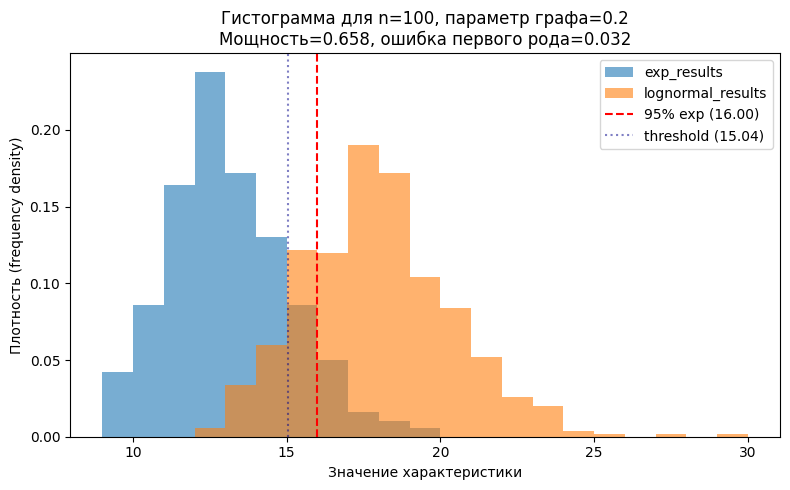

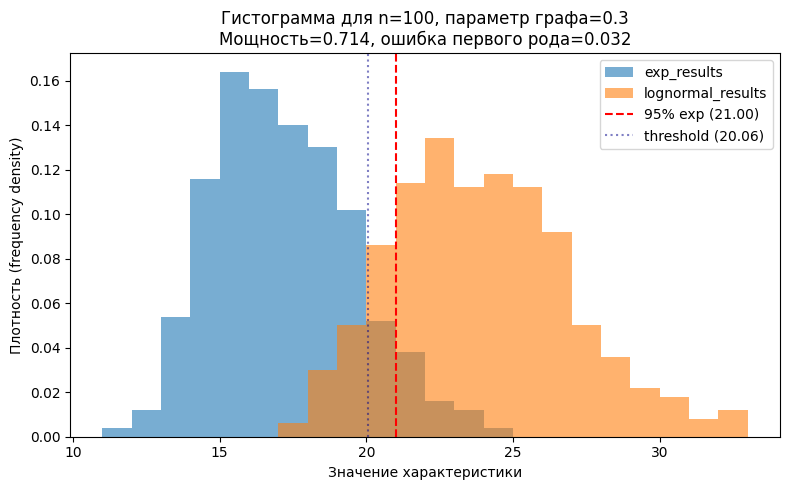

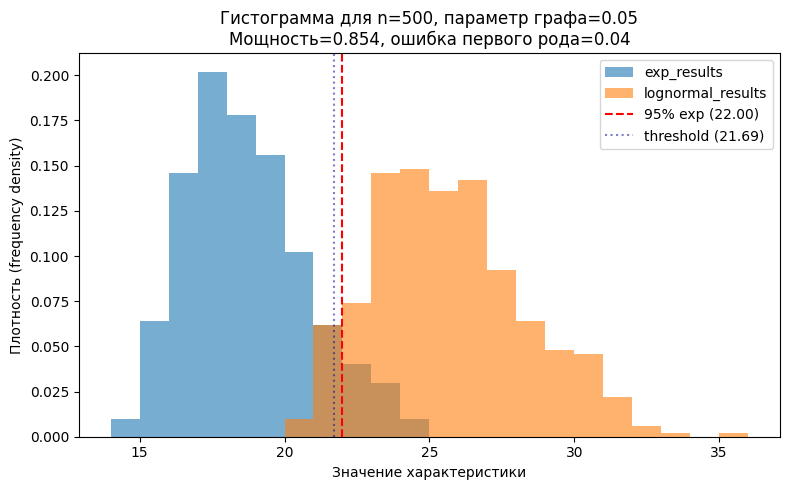

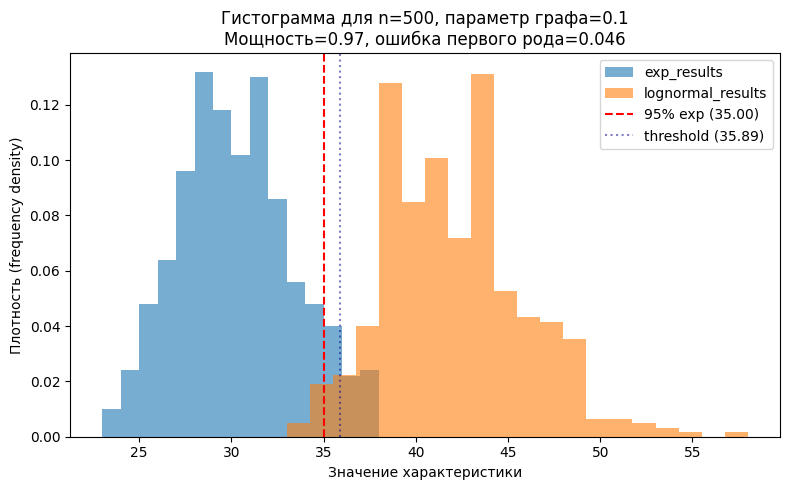

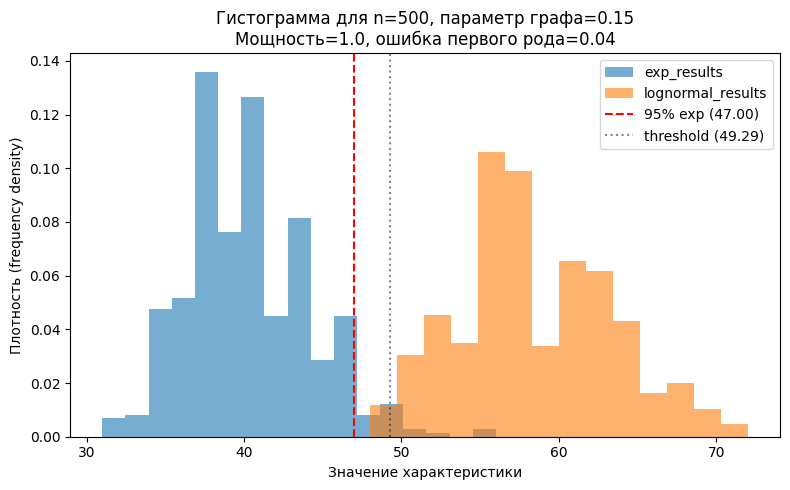

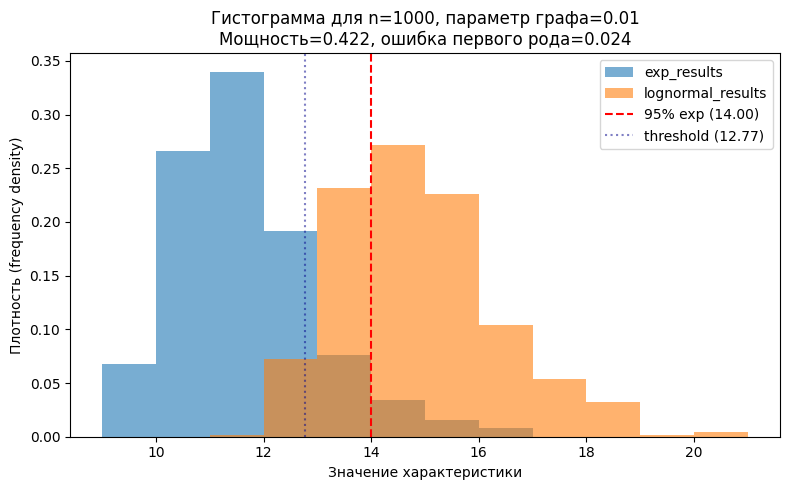

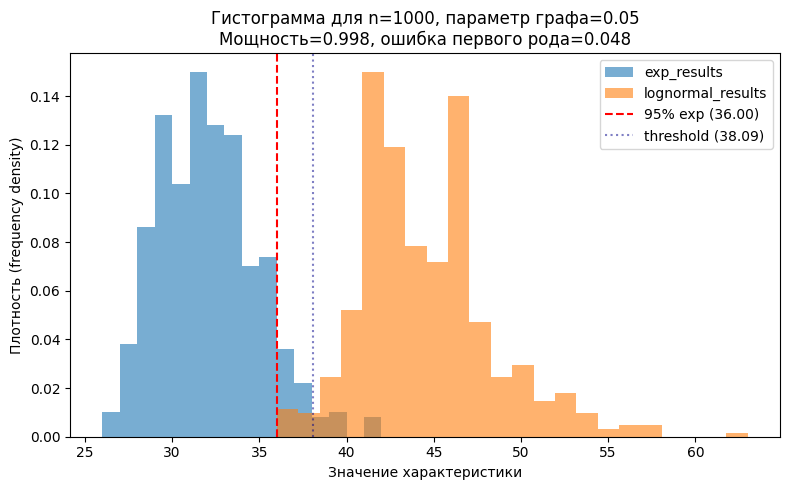

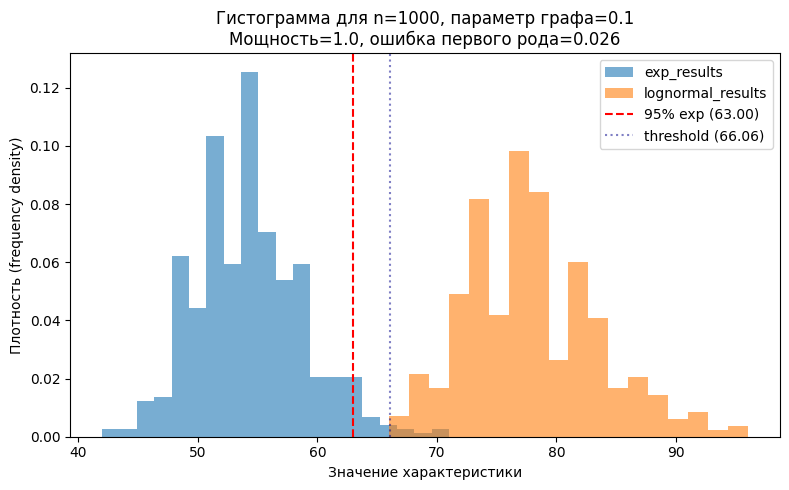

In [132]:
metrics_dist = []

for i, n in enumerate(n_array):
    for d in d_array[i]:
        exp_results = monte_carlo(M, n, lam0, d, generate_exp, build_distance_graph, get_clique_number)
        lognormal_results = monte_carlo(M, n, sigma0, d, generate_lognormal, build_distance_graph, get_clique_number)
        metrics_dist.append(analyze(n, d, exp_results, lognormal_results))


Выведем таблицу с основными статистическими метриками:

In [58]:
df_metrics = pd.DataFrame(metrics_dist)

In [59]:
df_metrics

n  graph_param  power  alpha  p95_exp  threshold  mean_exp    var_exp  \
0     25         0.20  0.238  0.042     6.00      5.202     4.600   1.090180   
1     25         0.40  0.254  0.014     9.00      7.459     6.406   1.744653   
2     25         0.60  0.302  0.032    11.00      9.329     7.994   2.466898   
3    100         0.10  0.414  0.028    11.00      9.828     8.414   1.974553   
4    100         0.20  0.622  0.036    16.00     15.171    12.852   3.974044   
5    100         0.30  0.742  0.044    21.00     20.185    16.758   6.356148   
6    500         0.05  0.942  0.050    21.05     21.552    18.104   3.949082   
7    500         0.10  0.956  0.040    36.00     36.251    30.168  10.893563   
8    500         0.15  0.990  0.048    47.00     49.196    40.648  16.144385   
9   1000         0.01  0.728  0.038    13.00     12.846    11.094   1.620405   
10  1000         0.05  0.994  0.042    37.00     38.212    31.930   9.468036   
11  1000         0.10  1.000  0.050    61.05     66.020    54.188  19.804265   

     std_exp    se_exp  mean_log    var_log   std_log    se_log  
0   1.044117  0.046694     5.804   1.636858  1.279397  0.057216  
1   1.320853  0.059070     8.512   2.903663  1.704014  0.076206  
2   1.570636  0.070241    10.664   3.686477  1.920020  0.085866  
3   1.405188  0.062842    11.242   2.889214  1.699769  0.076016  
4   1.993500  0.089152    17.490   6.134168  2.476725  0.110763  
5   2.521140  0.112749    23.612  10.253964  3.202181  0.143206  
6   1.987230  0.088872    25.000   6.601202  2.569281  0.114902  
7   3.300540  0.147605    42.334  16.110665  4.013809  0.179503  
8   4.018008  0.179691    57.744  20.976417  4.580002  0.204824  
9   1.272951  0.056928    14.598   2.693784  1.641275  0.073400  
10  3.077017  0.137608    44.494  12.747459  3.570358  0.159671  
11  4.450198  0.199019    77.852  29.789675  5.457992  0.244089

**Вывод:**\
Могу предположить, что при росте `n` метрики увеличиваются, данная зависимость похожа на линейную. Думаю, что на данный момент оптимальным `n = 500`, так как он дает хорошие метрики и довольно быстро работает. \
С `d` ситуация сложнее: предполагаю, что при фиксированном `n` метрики зависят параболически от `d`, так как при большом `d` граф становится слишком плотный, следовательно, теряет информацию. 

Поэтому я решил сделать еще одно исследование: зафиксировать `n = 500` и посмотреть как ведут себя метрики прри измении `d` в более широком диапазоне.

Для `n > 500` и `d > 0.3` скорость расчетов уже довольно низкая, поэтому у меня появилась идея распараллелить все вычисления.

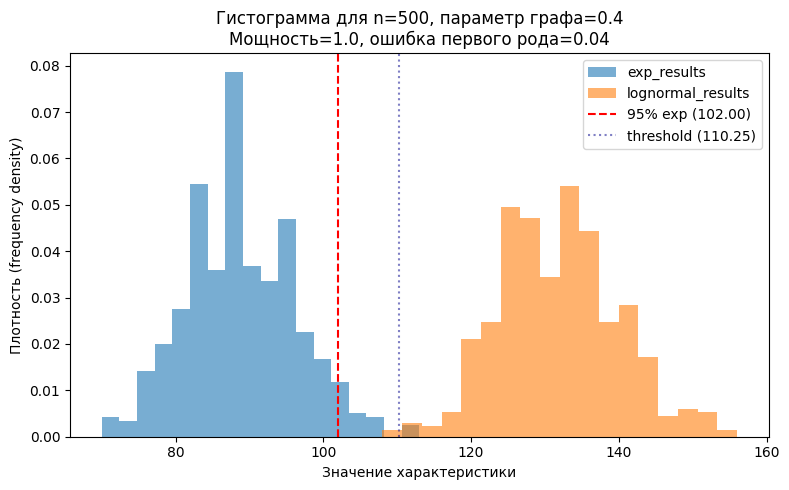

In [136]:
M = 500
N = 500
D = 0.4
metrics_dist_500 = []

exp_results = monte_carlo(M, N, lam0, D, generate_exp, build_distance_graph, get_clique_number)
lognormal_results = monte_carlo(M, N, sigma0, D, generate_lognormal, build_distance_graph, get_clique_number)
metrics_dist_500.append(analyze(N, D, exp_results, lognormal_results))

Данный код отработал примерно за `10` минут, посмотрим, сколько потребуется времени параллельному методу Монте-Карло.

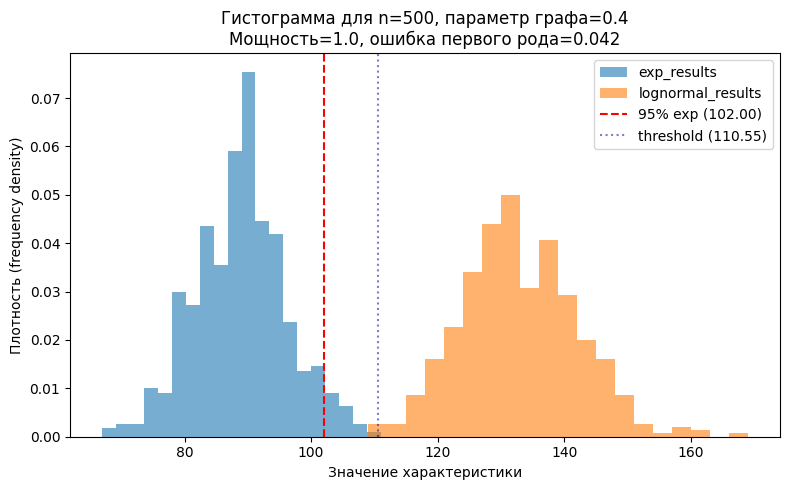

In [137]:
M = 500
N = 500
D = 0.4

exp_results = monte_carlo_multiprocessing(M, N, lam0, D, generate_exp, build_distance_graph, get_clique_number)
lognormal_results = monte_carlo_multiprocessing(M, N, sigma0, D, generate_lognormal, build_distance_graph, get_clique_number)
metrics_dist_500.append(analyze(N, D, exp_results, lognormal_results))

In [138]:
df_metrics = pd.DataFrame(metrics_dist_500)

In [139]:
df_metrics

n  graph_param  power  alpha  p95_exp  threshold  mean_exp    var_exp  \
0  500          0.4    1.0  0.040    102.0     110.25    88.784  55.664673   
1  500          0.4    1.0  0.042    102.0     110.55    88.784  52.402148   

    std_exp    se_exp  mean_log    var_log   std_log    se_log  
0  7.460876  0.333661   131.716  64.664673  8.041435  0.359624  
1  7.238933  0.323735   132.316  82.857860  9.102629  0.407082

Параллельный метод Монте-Карло отработал за `2` минуты при `n = 500` и `k = 0.4`, то есть мы получили прирост в скорости примерно в 5 раз. Теперь можем быстро посчитать, как влияет параметр `k` на метрики при фиксированном `n`.

In [147]:
M = 500
N = 500
d_array = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

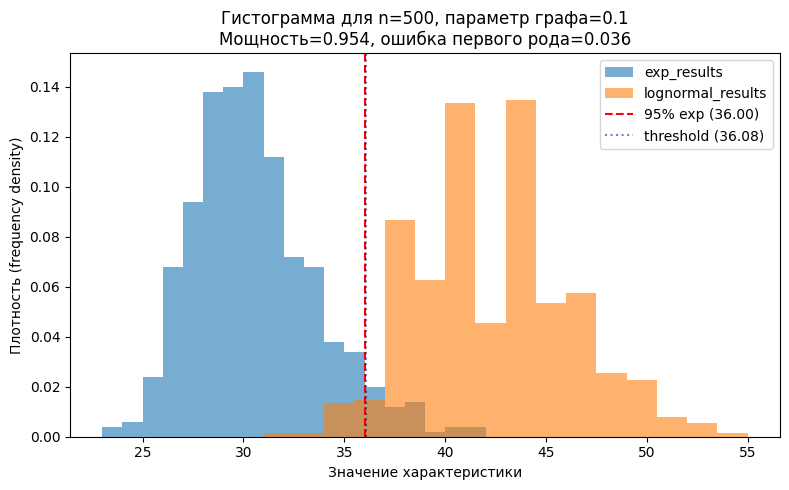

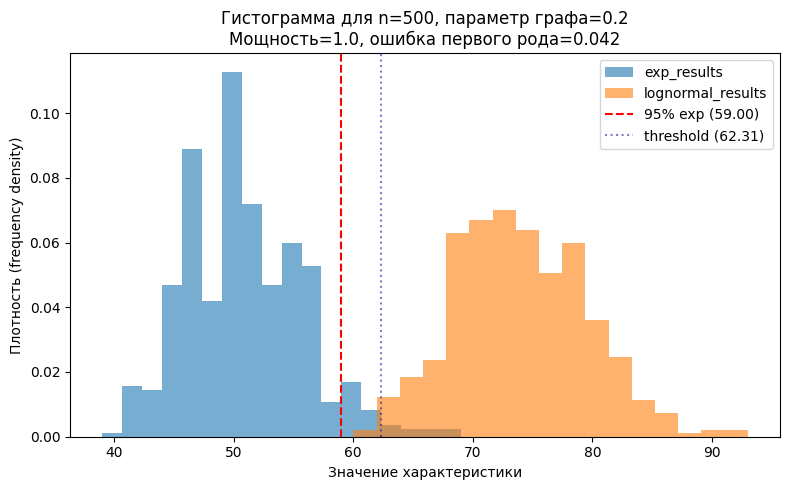

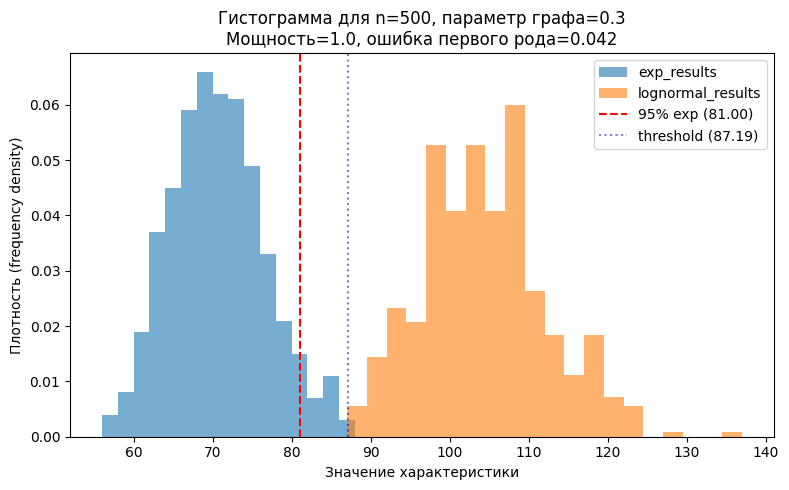

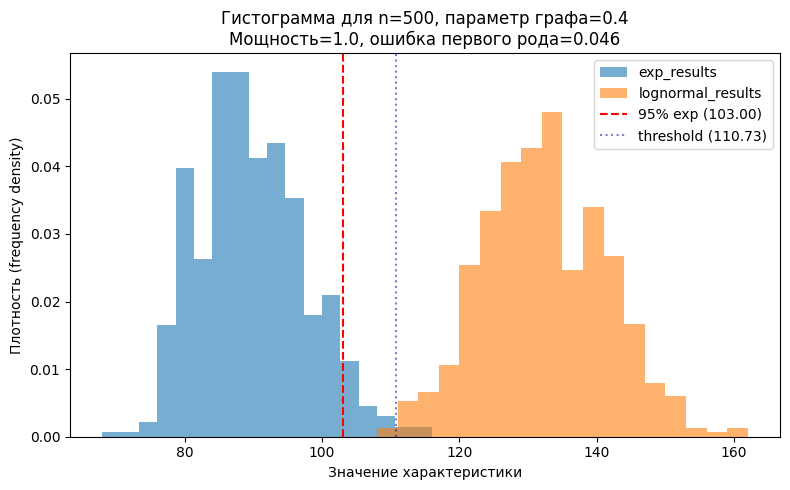

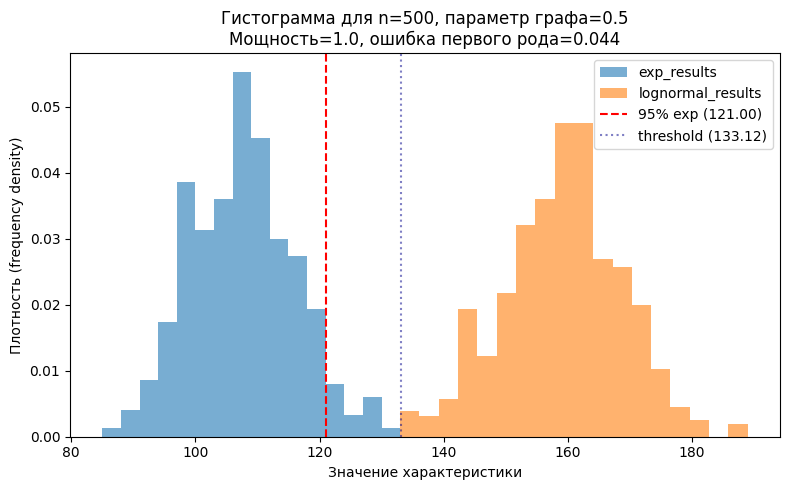

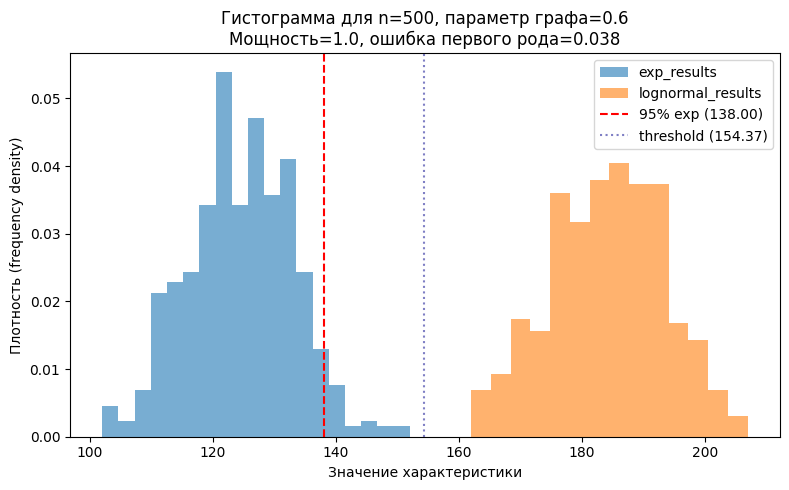

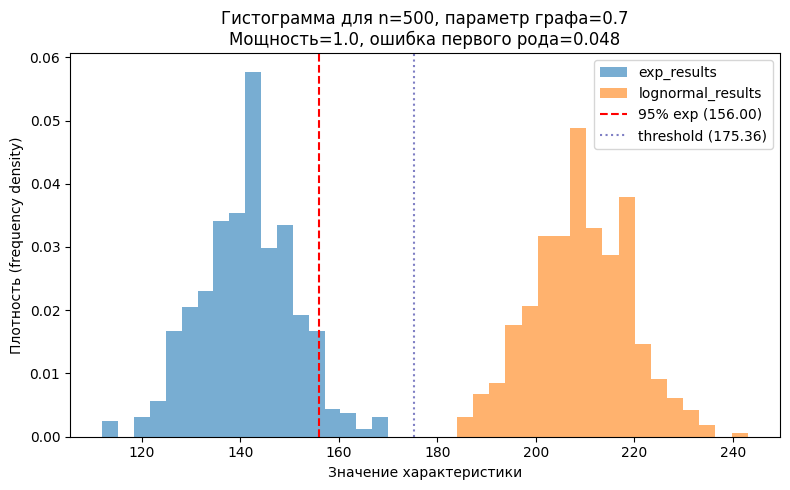

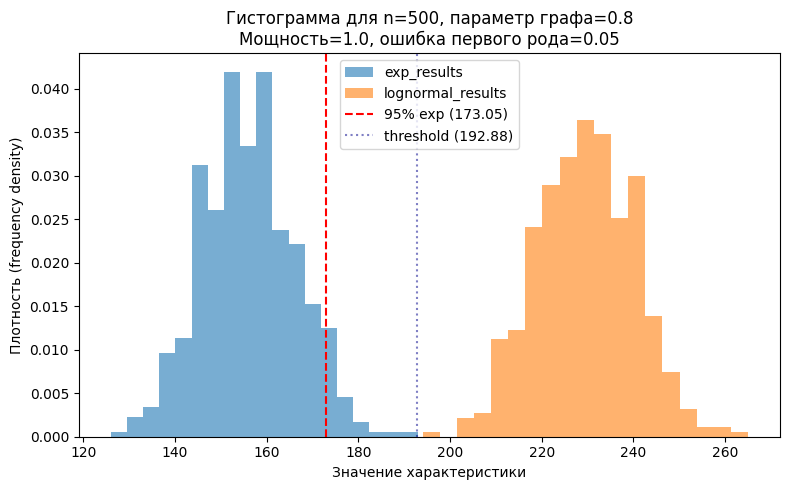

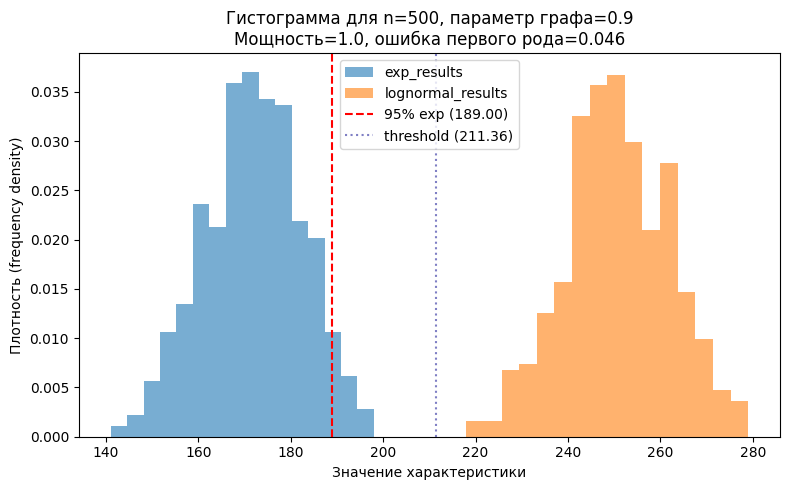

In [148]:
metrics_dist_500 = []

for d in d_array:
    exp_results = monte_carlo_multiprocessing(M, N, lam0, d, generate_exp, build_distance_graph, get_clique_number)
    lognormal_results = monte_carlo_multiprocessing(M, N, sigma0, d, generate_lognormal, build_distance_graph, get_clique_number)
    metrics_dist_500.append(analyze(N, d, exp_results, lognormal_results))

df_metrics = pd.DataFrame(metrics_dist_500)

In [149]:
df_metrics

n  graph_param  power  alpha  p95_exp  threshold  mean_exp     var_exp  \
0  500          0.1  0.954  0.036    36.00     36.080    30.048    9.420537   
1  500          0.2  1.000  0.042    59.00     62.307    50.690   23.532966   
2  500          0.3  1.000  0.042    81.00     87.188    70.220   35.983567   
3  500          0.4  1.000  0.046   103.00    110.734    89.594   59.107379   
4  500          0.5  1.000  0.044   121.00    133.116   107.148   71.204505   
5  500          0.6  1.000  0.038   138.00    154.367   124.534   73.074994   
6  500          0.7  1.000  0.048   156.00    175.358   141.386   90.994994   
7  500          0.8  1.000  0.050   173.05    192.878   156.206  103.434433   
8  500          0.9  1.000  0.046   189.00    211.364   171.970  114.602305   

     std_exp    se_exp  mean_log     var_log    std_log    se_log  
0   3.069289  0.137263    42.112   14.368192   3.790540  0.169518  
1   4.851079  0.216947    73.924   31.970164   5.654217  0.252864  
2   5.998630  0.268267   104.156   61.454573   7.839297  0.350584  
3   7.688132  0.343824   131.874   81.092309   9.005127  0.402722  
4   8.438276  0.377371   159.084   91.768481   9.579587  0.428412  
5   8.548391  0.382296   184.200   84.925852   9.215522  0.412131  
6   9.539130  0.426603   209.330   98.221543   9.910678  0.443219  
7  10.170272  0.454828   229.550  114.744990  10.711909  0.479051  
8  10.705247  0.478753   250.758  127.795026  11.304646  0.505559

**Выводы:**
* гипотеза о параболической зависимости метрик от `d` не подтвердилась. Было установлено, что при росте `n` и `d` метрики качества растут, но у `d` есть критический порог, после которого метрики растут незначительно или же вовсе не растут, этот порог для большинства `n` равен `d = 0.8`. 

Поэтому в дальнейших экспериментах я считаю разумно рассматривать дистанционные графы, в которых `d = 0.8`, так как это идеальный компромисс между качеством предсказания и скоростью работы.

In [175]:
M = 500
D = 0.8
n_array = [25, 100, 500]

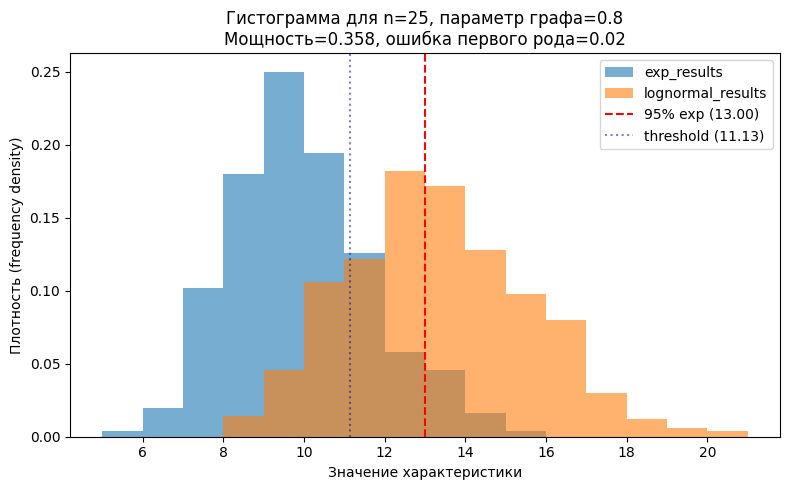

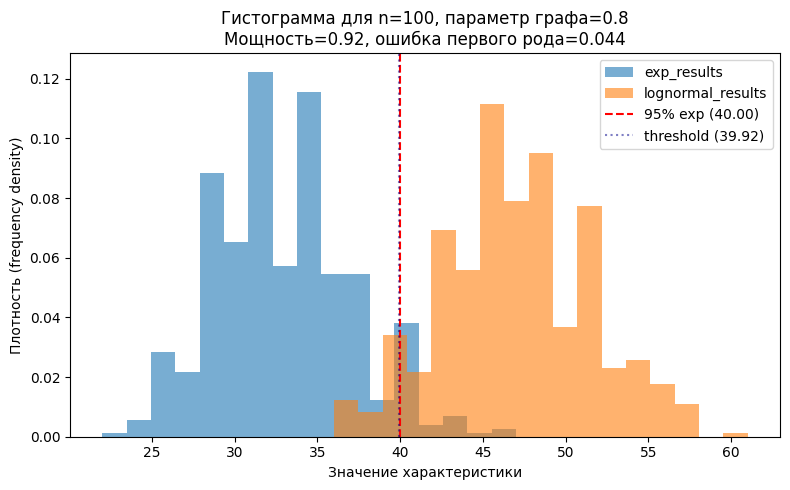

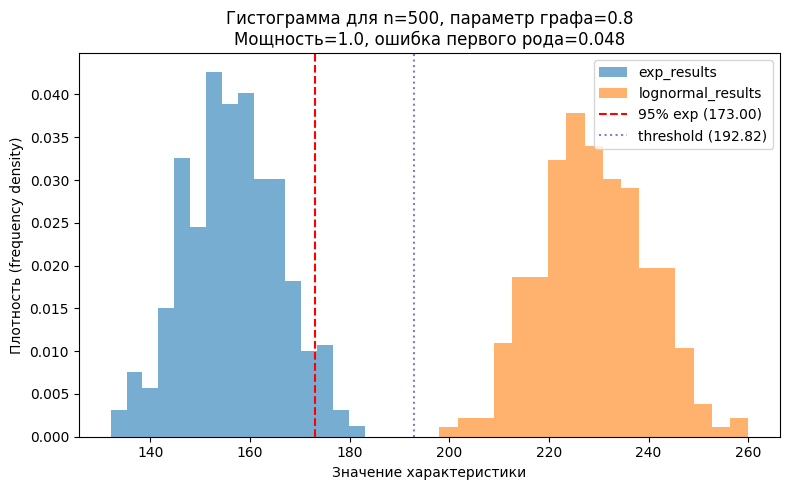

In [176]:
metrics_dist_final = []

for n in n_array:
    exp_results = monte_carlo_multiprocessing(M, n, lam0, D, generate_exp, build_distance_graph, get_clique_number)
    lognormal_results = monte_carlo_multiprocessing(M, n, sigma0, D, generate_lognormal, build_distance_graph, get_clique_number)
    metrics_dist_final.append(analyze(n, D, exp_results, lognormal_results))

df_metrics = pd.DataFrame(metrics_dist_final)

#### Исследуем KNN-граф

In [156]:
M = 500
n_array = [25, 100, 500]
k_array = [
    [2, 4, 7, 8, 9, 10, 12, 13, 16, 17, 22],
    [10, 12, 13, 16, 17, 22, 32, 64, 71],
    [32, 64, 100, 256, 316]
]

In [157]:
metrics_knn = []

for i, n in enumerate(n_array):
    for k in k_array[i]:
        if k >= n:
            continue
        exp_results = monte_carlo_multiprocessing(M, n, lam0, k, generate_exp, build_knn_graph, min_degree)
        lognormal_results = monte_carlo_multiprocessing(M, n, sigma0, k, generate_lognormal, build_knn_graph, min_degree)
        metrics_knn.append(analyze(n, k, exp_results, lognormal_results, need_hist=False))

Выведем таблицу с основными статистическими метриками:

In [158]:
df_metrics = pd.DataFrame(metrics_knn)

In [159]:
df_metrics

n  graph_param  power  alpha  p95_exp  threshold  mean_exp  var_exp  \
0    25            2    0.0    0.0      2.0        2.0       2.0      0.0   
1    25            4    0.0    0.0      4.0        4.0       4.0      0.0   
2    25            7    0.0    0.0      7.0        7.0       7.0      0.0   
3    25            8    0.0    0.0      8.0        8.0       8.0      0.0   
4    25            9    0.0    0.0      9.0        9.0       9.0      0.0   
5    25           10    0.0    0.0     10.0       10.0      10.0      0.0   
6    25           12    0.0    0.0     12.0       12.0      12.0      0.0   
7    25           13    0.0    0.0     13.0       13.0      13.0      0.0   
8    25           16    0.0    0.0     16.0       16.0      16.0      0.0   
9    25           17    0.0    0.0     17.0       17.0      17.0      0.0   
10   25           22    0.0    0.0     22.0       22.0      22.0      0.0   
11  100           10    0.0    0.0     10.0       10.0      10.0      0.0   
12  100           12    0.0    0.0     12.0       12.0      12.0      0.0   
13  100           13    0.0    0.0     13.0       13.0      13.0      0.0   
14  100           16    0.0    0.0     16.0       16.0      16.0      0.0   
15  100           17    0.0    0.0     17.0       17.0      17.0      0.0   
16  100           22    0.0    0.0     22.0       22.0      22.0      0.0   
17  100           32    0.0    0.0     32.0       32.0      32.0      0.0   
18  100           64    0.0    0.0     64.0       64.0      64.0      0.0   
19  100           71    0.0    0.0     71.0       71.0      71.0      0.0   
20  500           32    0.0    0.0     32.0       32.0      32.0      0.0   
21  500           64    0.0    0.0     64.0       64.0      64.0      0.0   
22  500          100    0.0    0.0    100.0      100.0     100.0      0.0   
23  500          256    0.0    0.0    256.0      256.0     256.0      0.0   
24  500          316    0.0    0.0    316.0      316.0     316.0      0.0   

    std_exp  se_exp  mean_log  var_log  std_log  se_log  
0       0.0     0.0       2.0      0.0      0.0     0.0  
1       0.0     0.0       4.0      0.0      0.0     0.0  
2       0.0     0.0       7.0      0.0      0.0     0.0  
3       0.0     0.0       8.0      0.0      0.0     0.0  
4       0.0     0.0       9.0      0.0      0.0     0.0  
5       0.0     0.0      10.0      0.0      0.0     0.0  
6       0.0     0.0      12.0      0.0      0.0     0.0  
7       0.0     0.0      13.0      0.0      0.0     0.0  
8       0.0     0.0      16.0      0.0      0.0     0.0  
9       0.0     0.0      17.0      0.0      0.0     0.0  
10      0.0     0.0      22.0      0.0      0.0     0.0  
11      0.0     0.0      10.0      0.0      0.0     0.0  
12      0.0     0.0      12.0      0.0      0.0     0.0  
13      0.0     0.0      13.0      0.0      0.0     0.0  
14      0.0     0.0      16.0      0.0      0.0     0.0  
15      0.0     0.0      17.0      0.0      0.0     0.0  
16      0.0     0.0      22.0      0.0      0.0     0.0  
17      0.0     0.0      32.0      0.0      0.0     0.0  
18      0.0     0.0      64.0      0.0      0.0     0.0  
19      0.0     0.0      71.0      0.0      0.0     0.0  
20      0.0     0.0      32.0      0.0      0.0     0.0  
21      0.0     0.0      64.0      0.0      0.0     0.0  
22      0.0     0.0     100.0      0.0      0.0     0.0  
23      0.0     0.0     256.0      0.0      0.0     0.0  
24      0.0     0.0     316.0      0.0      0.0     0.0

**Вывод:**\
Очевидно, что характеристика минимальная степень вершины для KNN-графа не очень оптимальная, потому что не дает никакой информации о графе, следовательно, и о распределении, так как у KNN-графа степень всех вершин равна `k`. Попробуем рассмотреть другую характеристику для KNN-графа.

Я думаю, что будет целесообразно рассмотреть кол-во треугольников в графе.

In [165]:
M = 500
n_array = [25, 100, 500]
k_array = [
    [2, 4, 7, 8, 9, 10, 12, 13, 16, 17, 22],
    [10, 12, 13, 16, 17, 22, 32, 64, 71],
    [32, 64, 100, 256, 316]
]

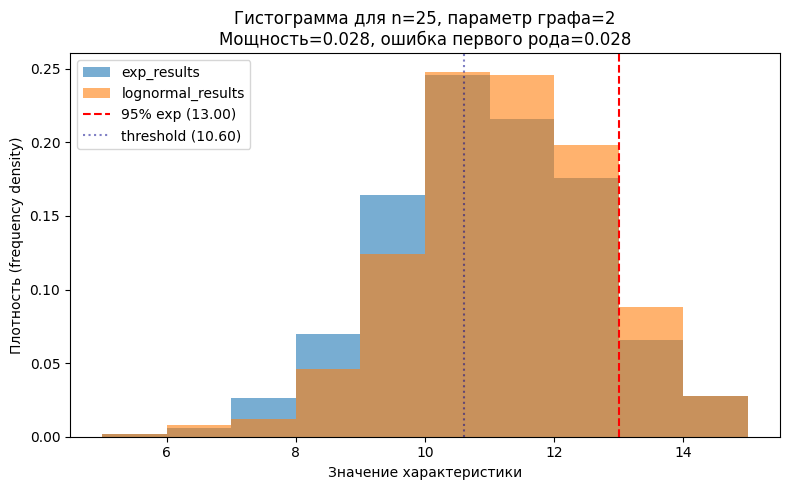

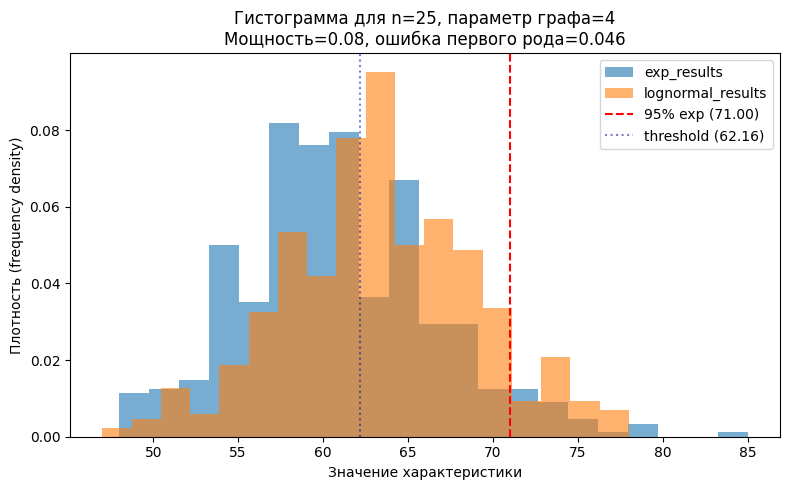

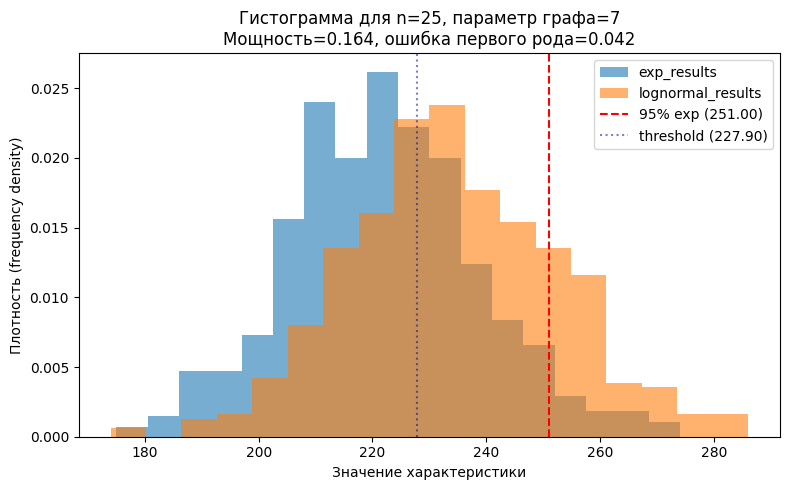

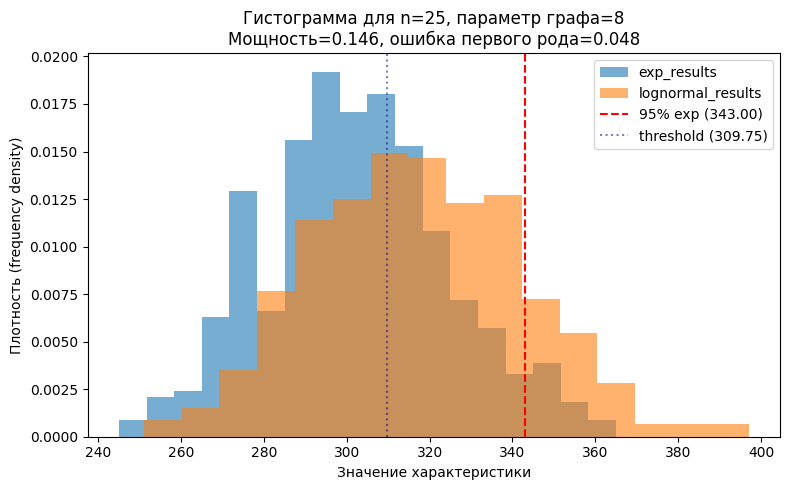

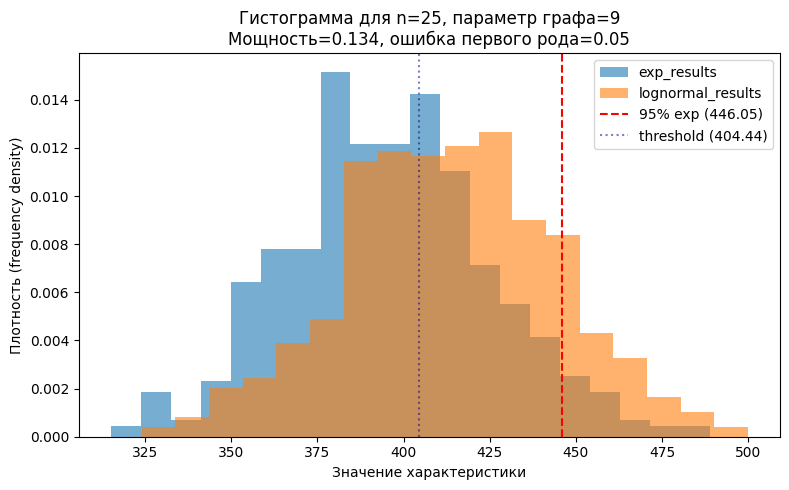

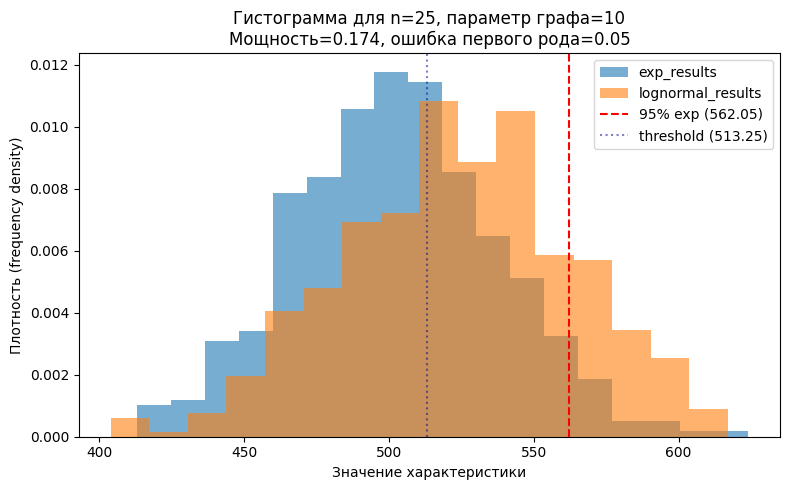

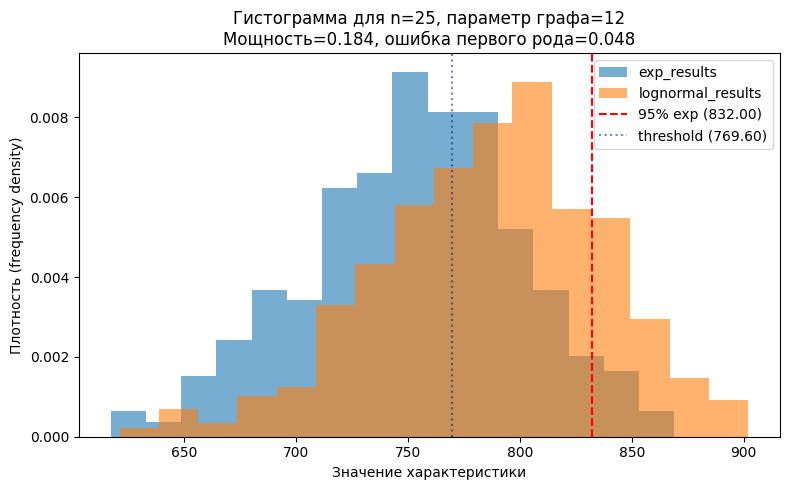

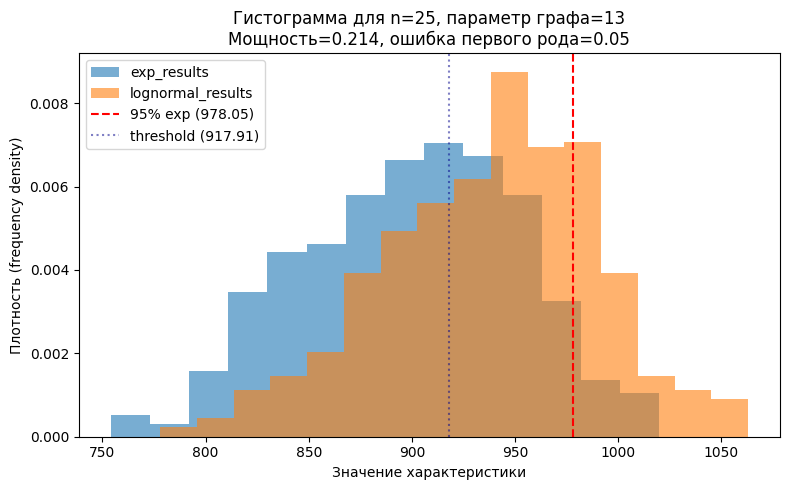

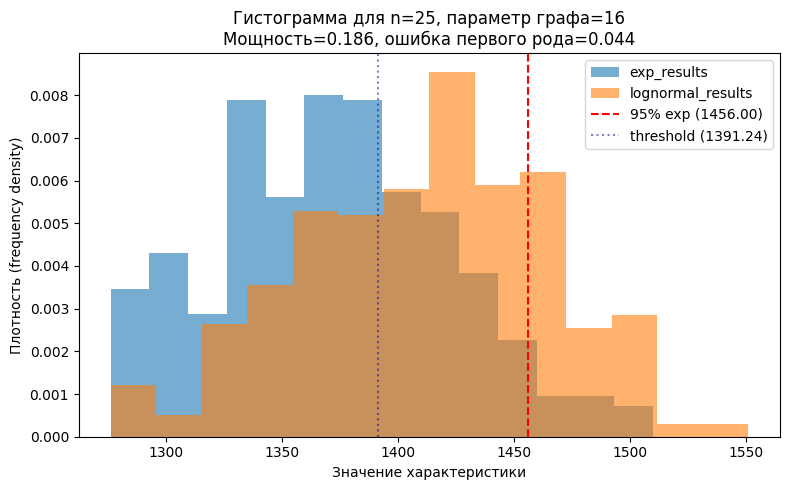

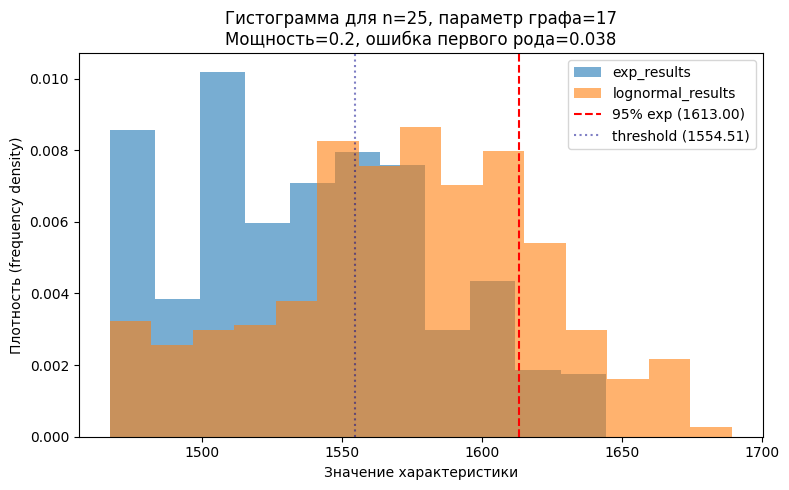

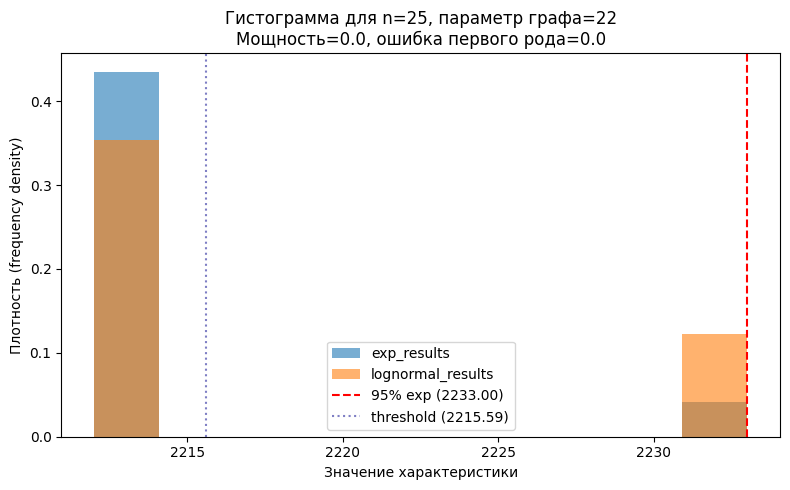

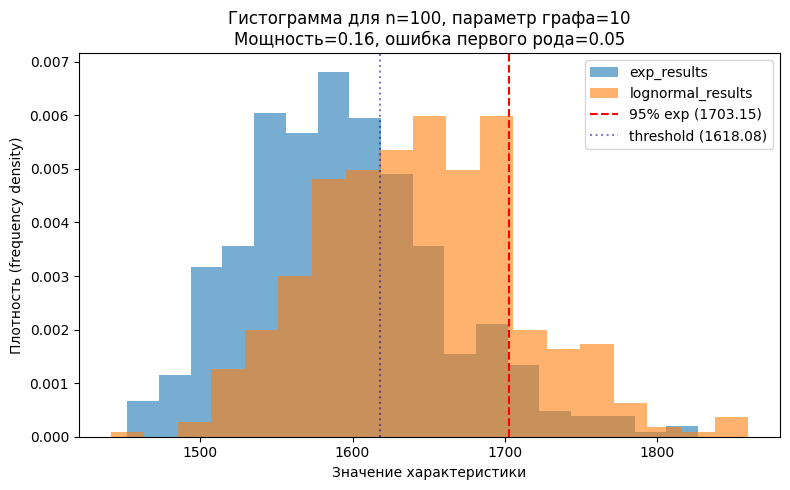

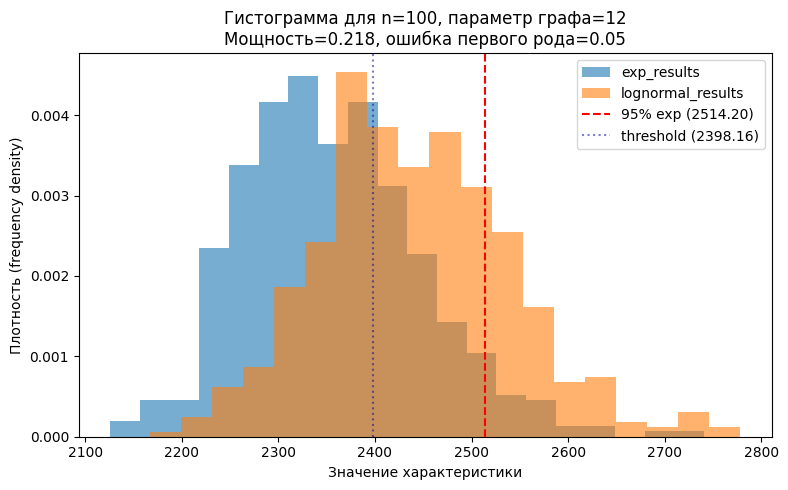

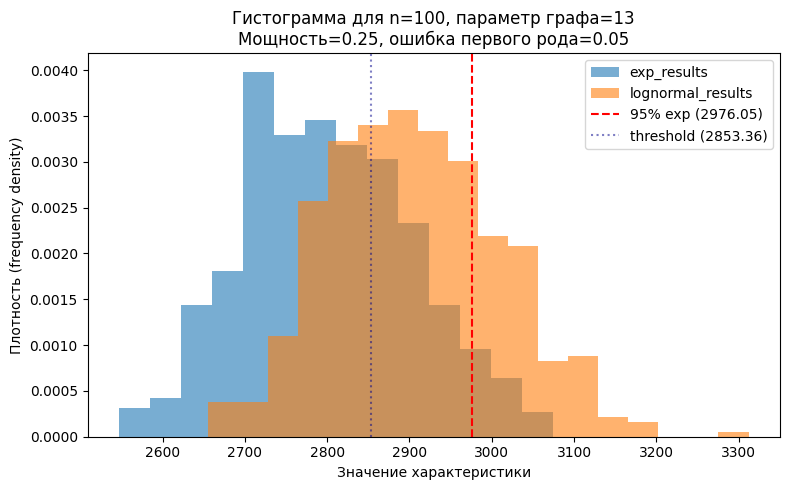

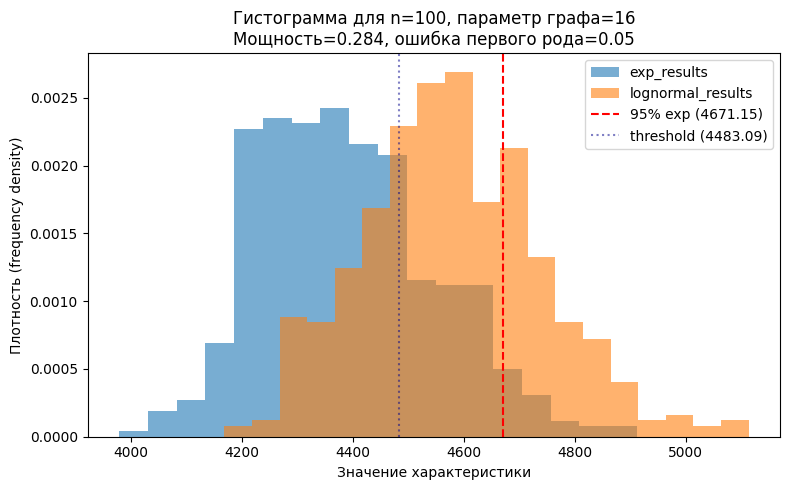

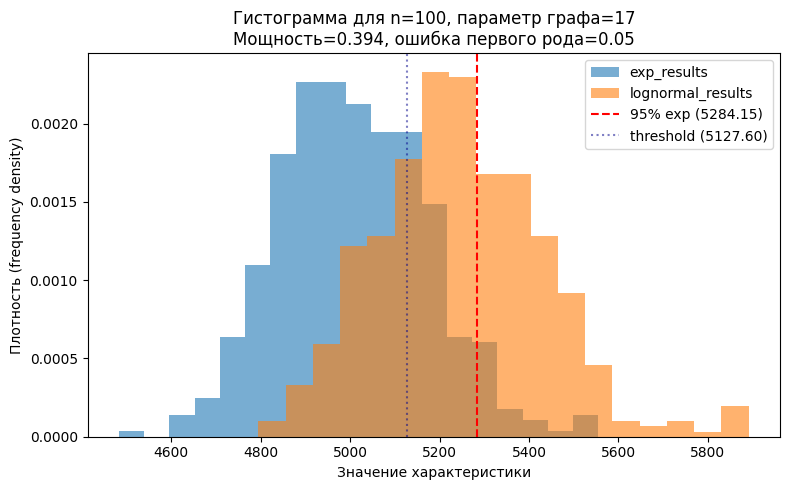

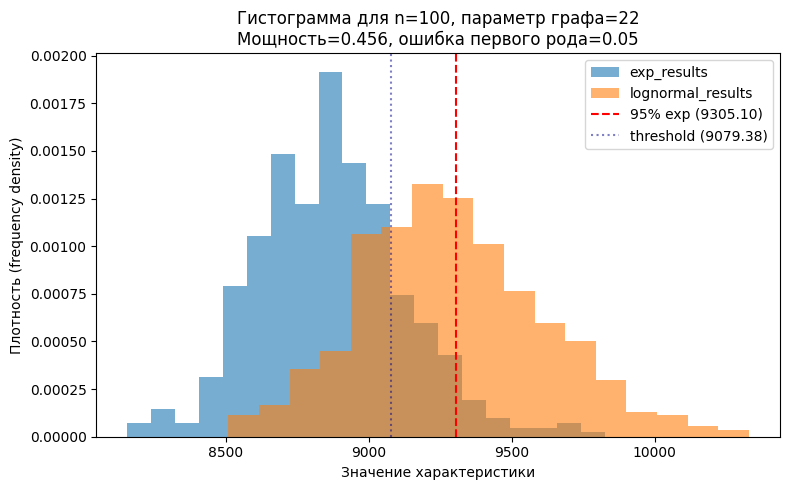

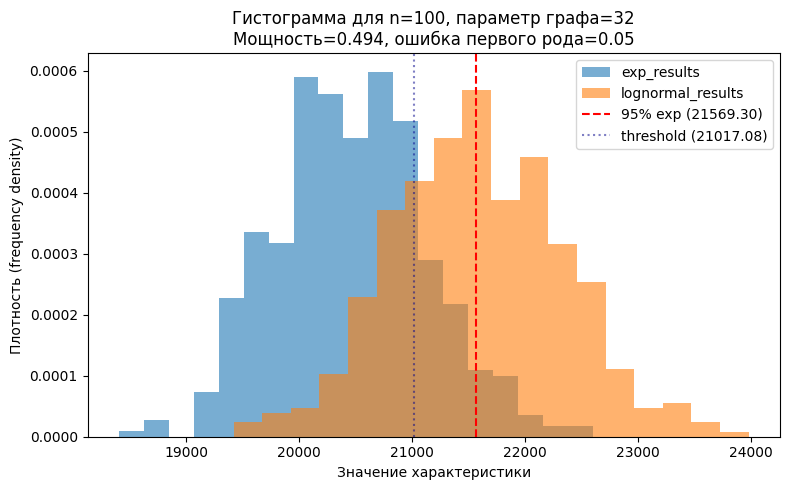

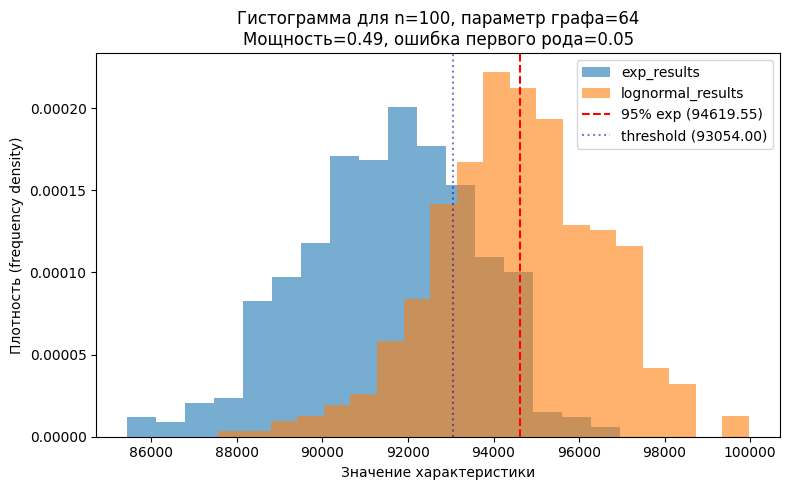

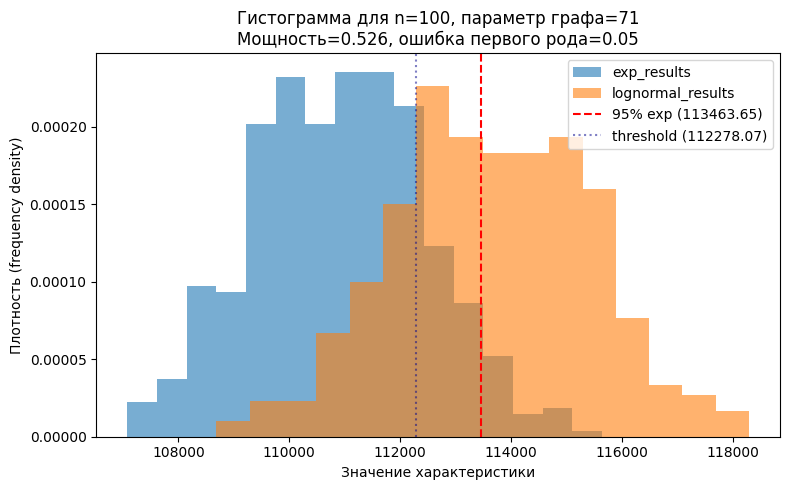

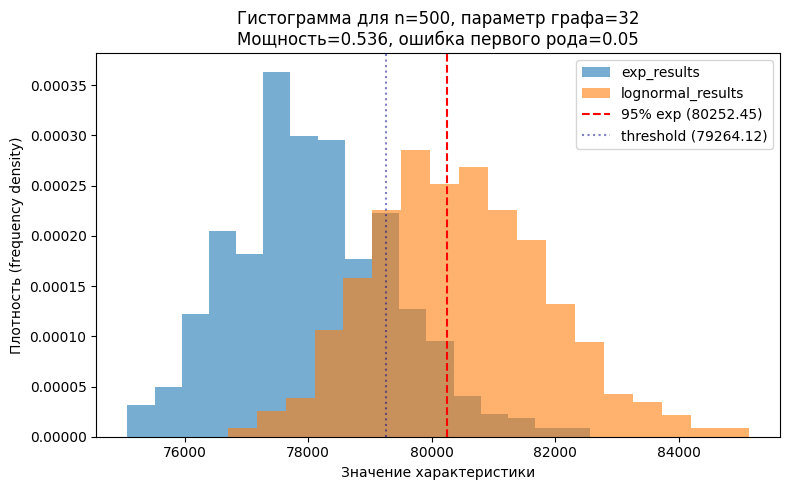

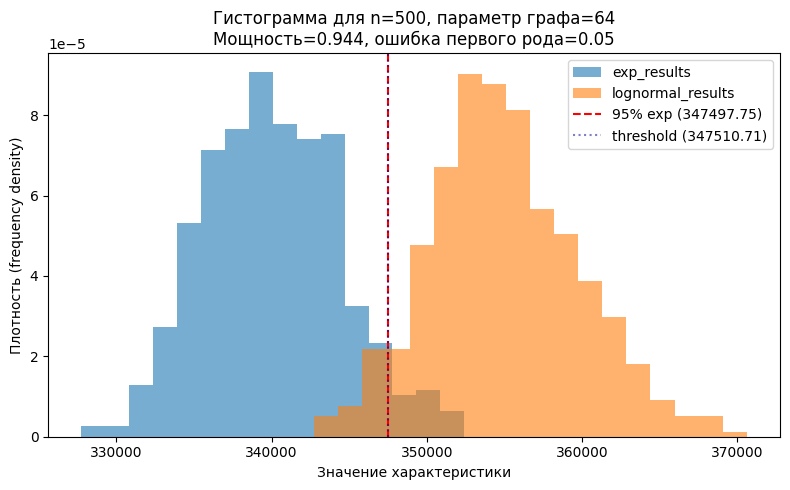

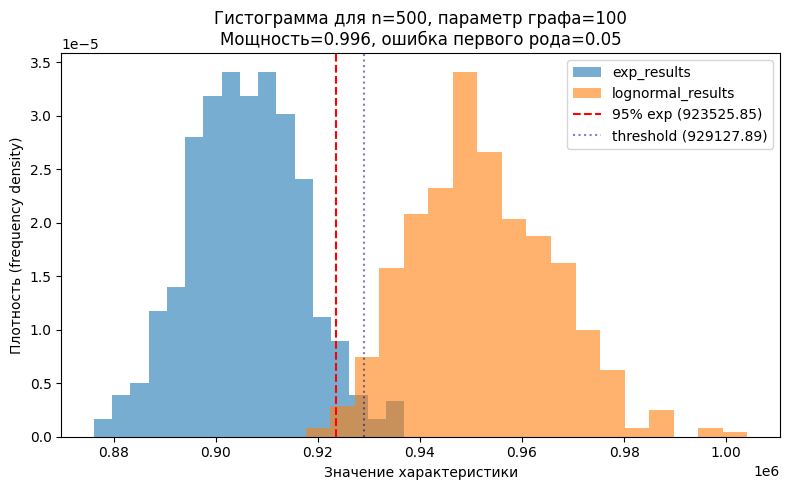

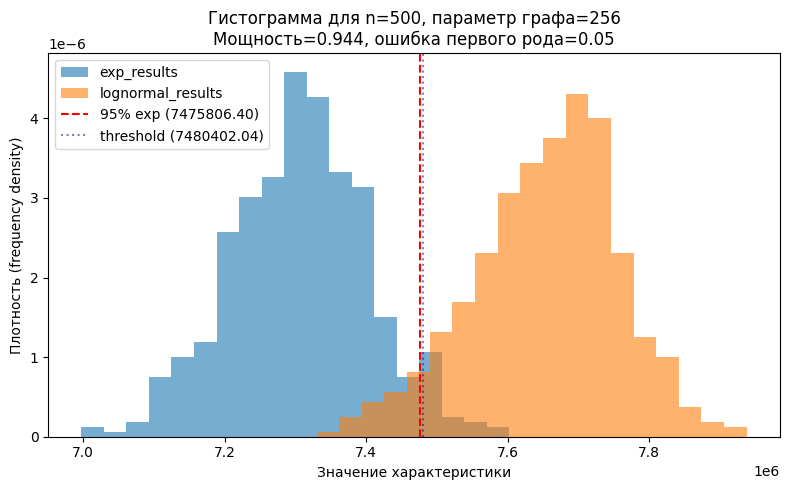

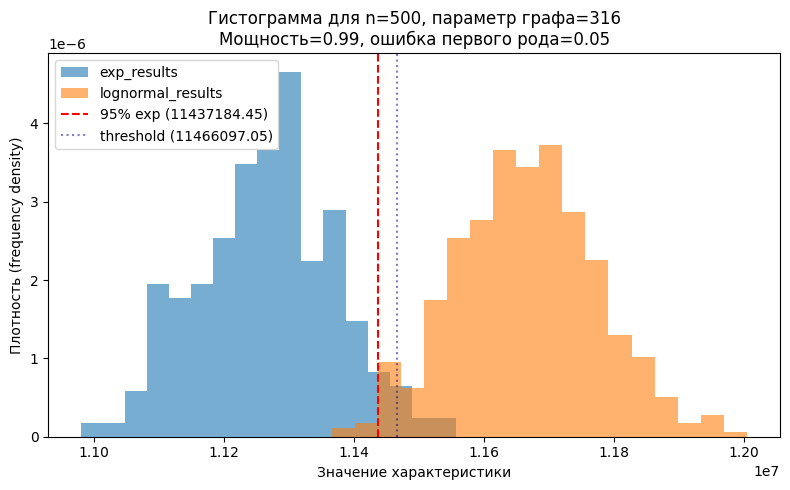

In [166]:
metrics_knn = []

for i, n in enumerate(n_array):
    for k in k_array[i]:
        if k >= n:
            continue
        exp_results = monte_carlo_multiprocessing(M, n, lam0, k, generate_exp, build_knn_graph, num_triangles)
        lognormal_results = monte_carlo_multiprocessing(M, n, sigma0, k, generate_lognormal, build_knn_graph, num_triangles)
        metrics_knn.append(analyze(n, k, exp_results, lognormal_results))

Выведем таблицу с основными статистическими метриками:

In [177]:
df_metrics = pd.DataFrame(metrics_knn)

In [178]:
df_metrics

n  graph_param  power  alpha      p95_exp     threshold      mean_exp  \
0    25            2  0.028  0.028        13.00  1.059800e+01  1.046800e+01   
1    25            4  0.080  0.046        71.00  6.216200e+01  6.092800e+01   
2    25            7  0.164  0.042       251.00  2.279010e+02  2.217240e+02   
3    25            8  0.146  0.048       343.00  3.097470e+02  3.024300e+02   
4    25            9  0.134  0.050       446.05  4.044400e+02  3.958260e+02   
5    25           10  0.174  0.050       562.05  5.132480e+02  5.025960e+02   
6    25           12  0.184  0.048       832.00  7.696030e+02  7.525440e+02   
7    25           13  0.214  0.050       978.05  9.179070e+02  8.981440e+02   
8    25           16  0.186  0.044      1456.00  1.391235e+03  1.371292e+03   
9    25           17  0.200  0.038      1613.00  1.554515e+03  1.537008e+03   
10   25           22  0.000  0.000      2233.00  2.215591e+03  2.213806e+03   
11  100           10  0.160  0.050      1703.15  1.618076e+03  1.593088e+03   
12  100           12  0.218  0.050      2514.20  2.398159e+03  2.355882e+03   
13  100           13  0.250  0.050      2976.05  2.853363e+03  2.800474e+03   
14  100           16  0.284  0.050      4671.15  4.483090e+03  4.387850e+03   
15  100           17  0.394  0.050      5284.15  5.127596e+03  5.007384e+03   
16  100           22  0.456  0.050      9305.10  9.079381e+03  8.869400e+03   
17  100           32  0.494  0.050     21569.30  2.101708e+04  2.046055e+04   
18  100           64  0.490  0.050     94619.55  9.305400e+04  9.153983e+04   
19  100           71  0.526  0.050    113463.65  1.122781e+05  1.109117e+05   
20  500           32  0.536  0.050     80252.45  7.926412e+04  7.807263e+04   
21  500           64  0.944  0.050    347497.75  3.475107e+05  3.400305e+05   
22  500          100  0.996  0.050    923525.85  9.291279e+05  9.058667e+05   
23  500          256  0.944  0.050   7475806.40  7.480402e+06  7.307037e+06   
24  500          316  0.990  0.050  11437184.45  1.146610e+07  1.126561e+07   

         var_exp        std_exp       se_exp      mean_log       var_log  \
0   2.626228e+00       1.620564     0.072474  1.072800e+01  2.382782e+00   
1   3.266414e+01       5.715255     0.255594  6.339600e+01  3.143004e+01   
2   2.829337e+02      16.820633     0.752242  2.340780e+02  3.369097e+02   
3   5.011755e+02      22.386948     1.001175  3.170640e+02  6.538396e+02   
4   8.643725e+02      29.400212     1.314817  4.130540e+02  9.360632e+02   
5   1.214221e+03      34.845677     1.558346  5.239000e+02  1.554102e+03   
6   2.285038e+03      47.802073     2.137774  7.866620e+02  2.550132e+03   
7   2.789759e+03      52.818167     2.362100  9.376700e+02  2.716955e+03   
8   2.622832e+03      51.213596     2.290342  1.411178e+03  2.846616e+03   
9   1.906285e+03      43.661018     1.952580  1.572022e+03  2.462563e+03   
10  3.473383e+01       5.893542     0.263567  2.217376e+03  8.416295e+01   
11  4.130253e+03      64.267043     2.874110  1.643064e+03  4.348545e+03   
12  8.371655e+03      91.496751     4.091859  2.440436e+03  9.797228e+03   
13  1.059118e+04     102.913457     4.602430  2.906252e+03  1.104091e+04   
14  2.444244e+04     156.340770     6.991772  4.578330e+03  2.637482e+04   
15  2.748229e+04     165.777819     7.413809  5.247808e+03  3.433710e+04   
16  6.678940e+04     258.436458    11.557630  9.289362e+03  1.018937e+05   
17  4.404878e+05     663.692548    29.681233  2.157360e+04  5.772738e+05   
18  4.073831e+06    2018.373272    90.264397  9.456818e+04  3.743885e+06   
19  2.384365e+06    1544.138882    69.055990  1.136445e+05  3.091223e+06   
20  1.691936e+06    1300.744416    58.171059  8.045561e+04  2.017933e+06   
21  1.898722e+07    4357.432551   194.870308  3.549909e+05  2.301956e+07   
22  1.189709e+08   10907.376105   487.792689  9.523891e+05  1.893999e+08   
23  9.426614e+09   97090.750461  4342.030360  7.653768e+06  1.053742e+10   
24  1.107559e+10  105240.619514  4706.503585  1.166

**Вывод:**
* метрики качества для KNN-графа сильно зависят от `n` при маленьких `n` не удалось получить хороших предсказаний. При больших `n` качество не хуже, чем с дистанционным деревом.
* для наилучшего качества предсказаний следует брать $k = \frac{2}{3}n$

Я думаю, что для данной задачи лучше подходит дистанционное дерево, в дальнейшем буду использовать его.

## Исследуем, как ведет себя $Τ$ в зависимости от параметров распределения

In [191]:
def analyze_lam_sigma(lam, sigma, exp_results, lognormal_results, need_hist=True):
    mean_exp, var_exp, std_exp, se_exp = compute_stats(exp_results)
    mean_log, var_log, std_log, se_log = compute_stats(lognormal_results)
    p95_exp = np.percentile(exp_results, 95)
    threshold = (mean_exp + mean_log) / 2

    alpha = np.mean(exp_results > p95_exp)
    power = np.mean(lognormal_results > p95_exp)


    metrics = {
        'lambda': lam, 'sigma': sigma,
        'power': power,
        'alpha': alpha,
        'p95_exp': p95_exp,
        'threshold': threshold,
        'mean_exp': mean_exp, 'var_exp': var_exp, 'std_exp': std_exp, 'se_exp': se_exp,
        'mean_log': mean_log, 'var_log': var_log, 'std_log': std_log, 'se_log': se_log,
    }

    if not need_hist:
        return metrics

    fig, ax = plt.subplots(figsize=(8, 5))
    bins = 'auto'

    ax.hist(exp_results, bins=bins, alpha=0.6, label='exp_results', density=True)
    ax.hist(lognormal_results, bins=bins, alpha=0.6, label='lognormal_results', density=True)

    ax.axvline(p95_exp, color='red', linestyle='--',
                label=f'95% exp ({p95_exp:.2f})')
    
    ax.axvline(threshold, color='darkblue', alpha=0.5, linestyle=':',
                label=f'threshold ({threshold:.2f})')

    ax.set_title(f'Гистограмма для lambda={lam}, sigma={sigma}\nМощность={power}, ошибка первого рода={alpha}')
    ax.set_xlabel('Значение характеристики')
    ax.set_ylabel('Плотность (frequency density)')
    ax.legend()
    plt.tight_layout()
    plt.show()

    return metrics

#### Исследуем KNN-граф

In [187]:
n = 100
k = int(2 * n / 3)
d = 0.8

In [188]:
lam_array = [0.1, 0.25, 0.5, 1.0, 2.0, 4.0]
sigma_array = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0]

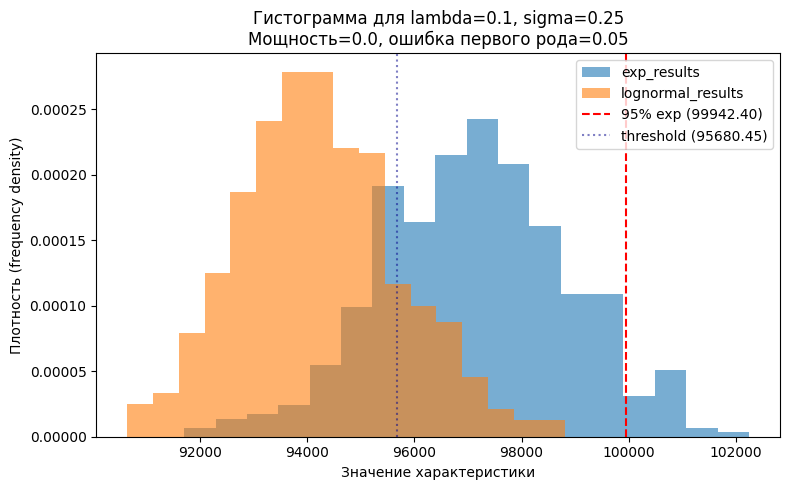

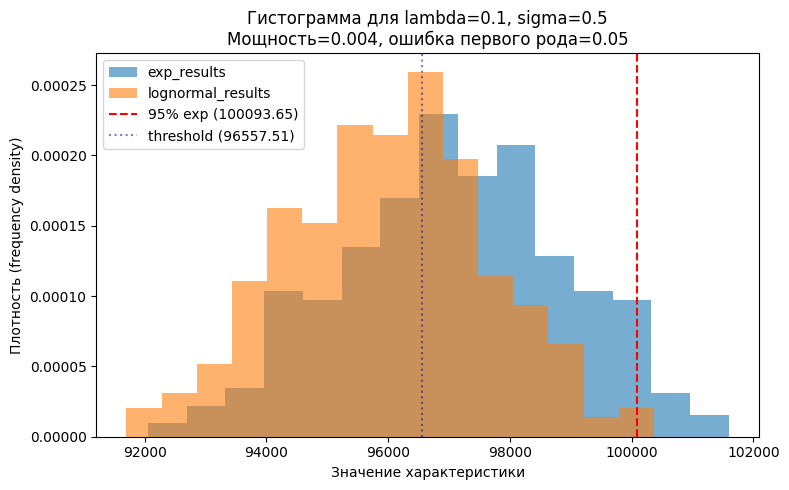

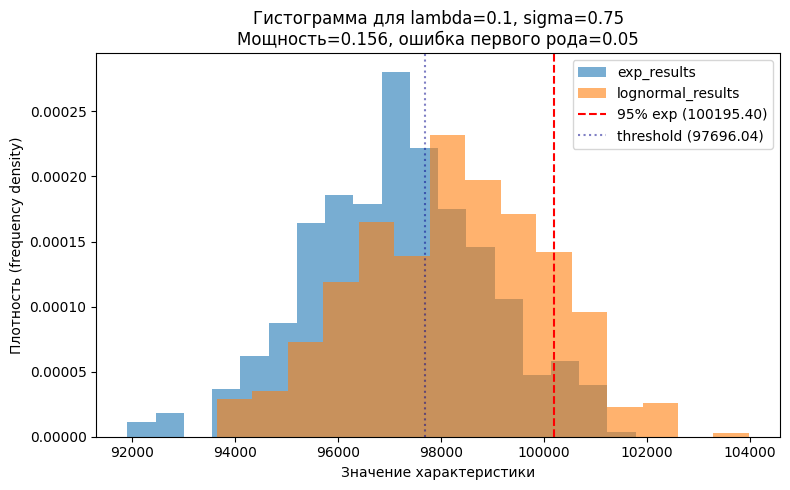

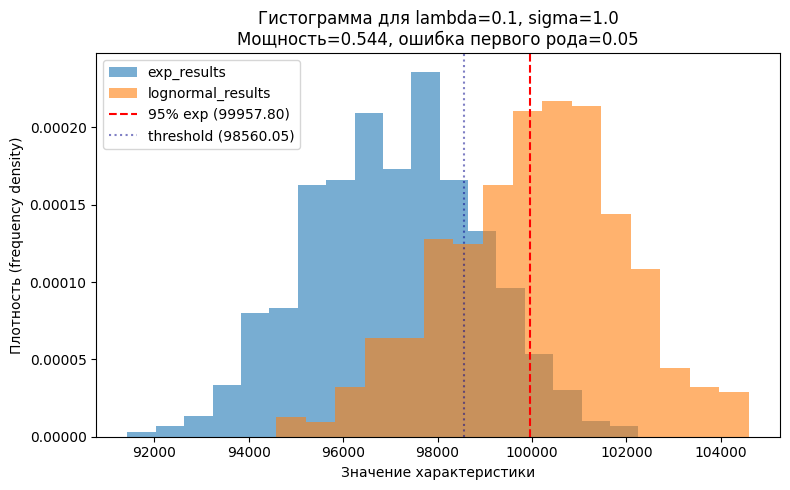

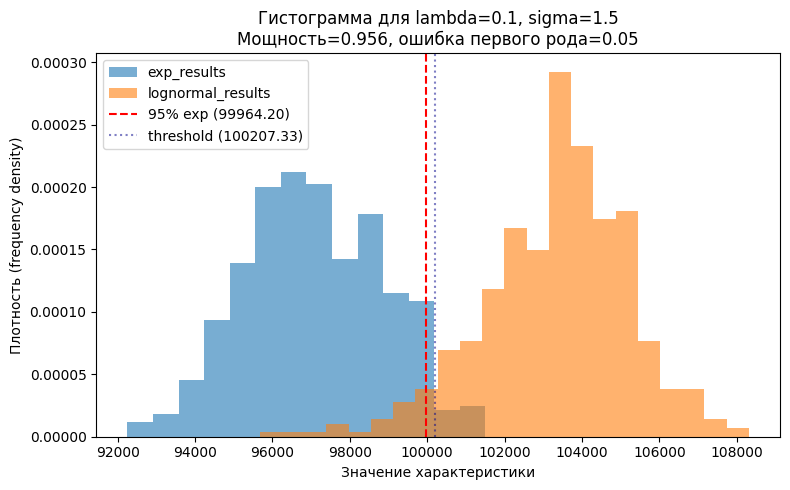

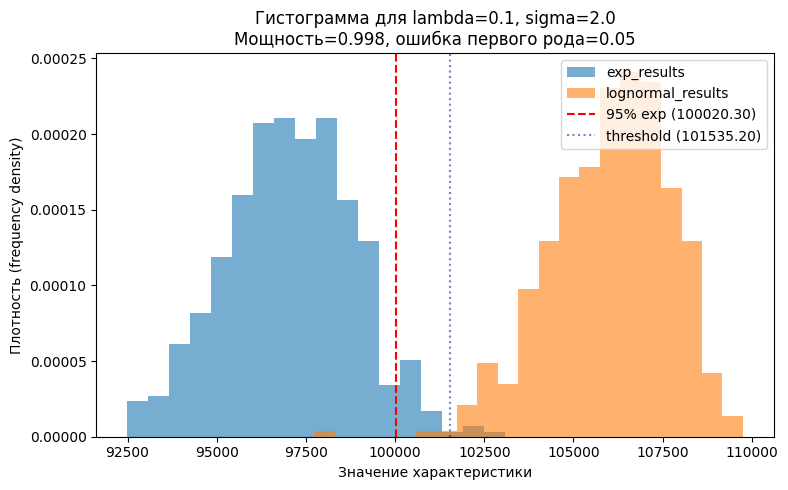

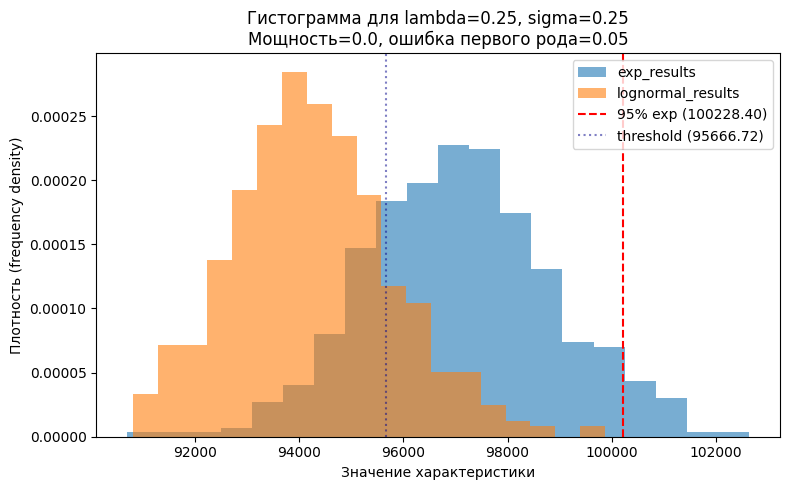

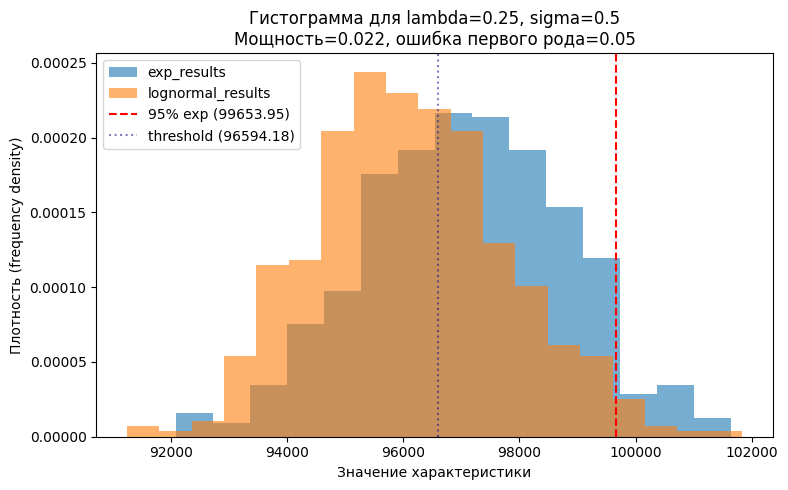

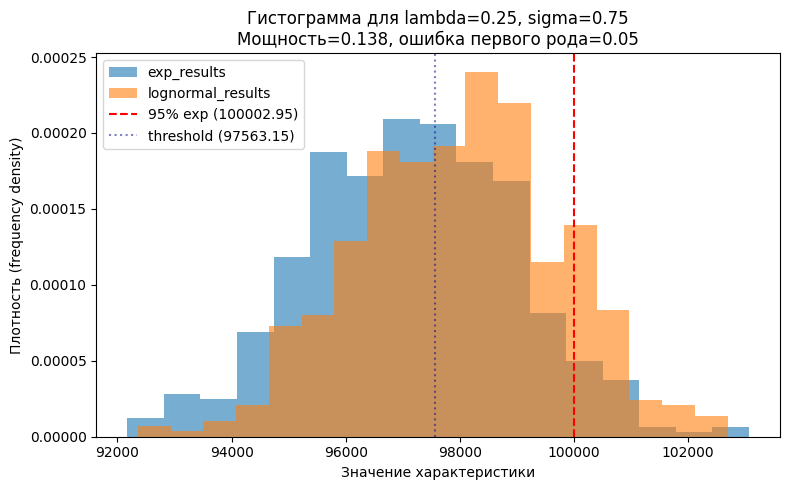

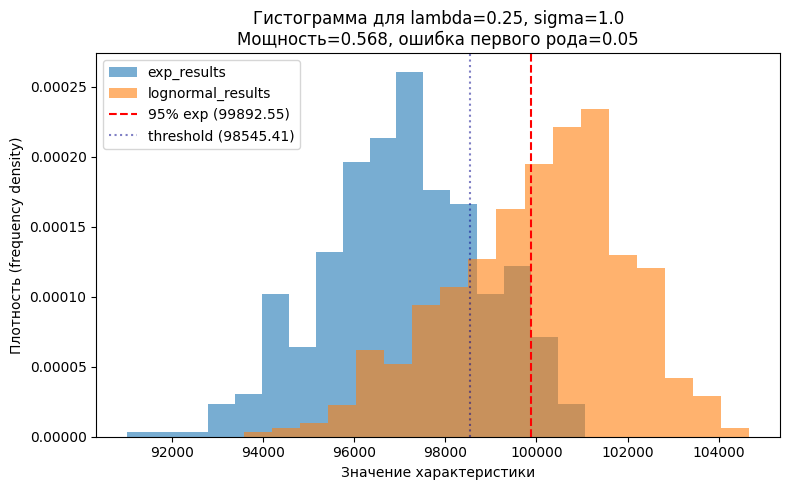

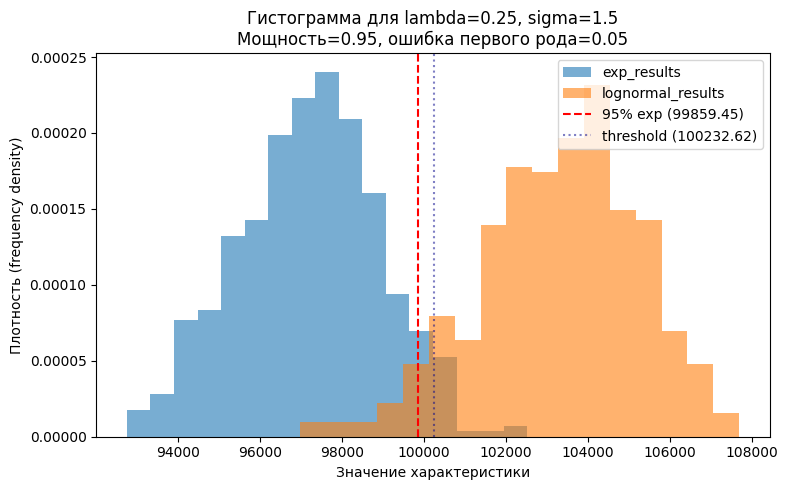

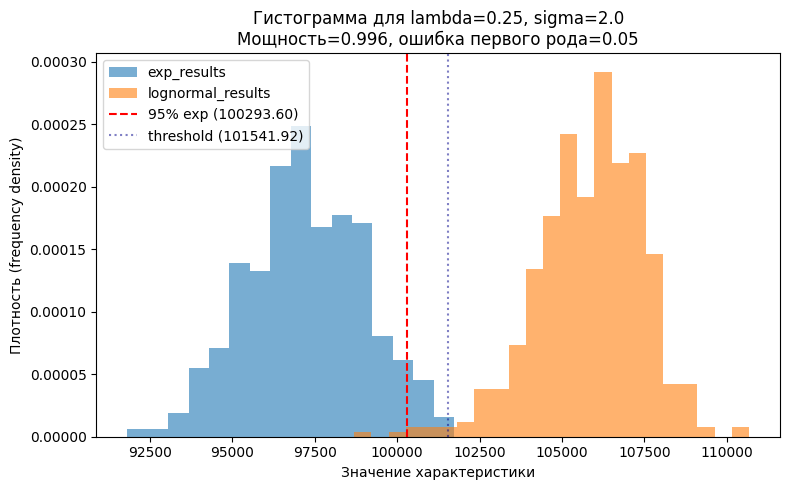

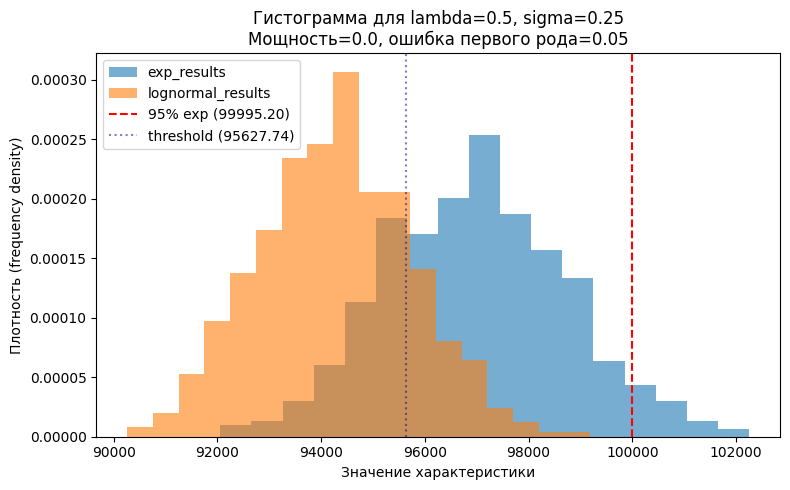

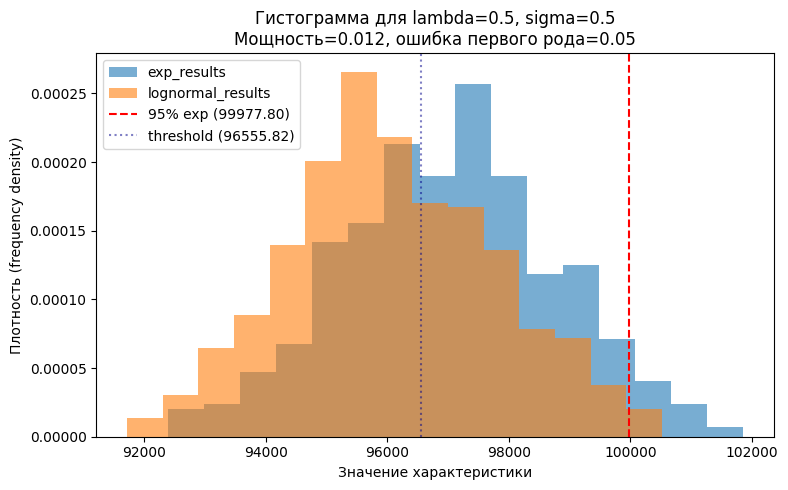

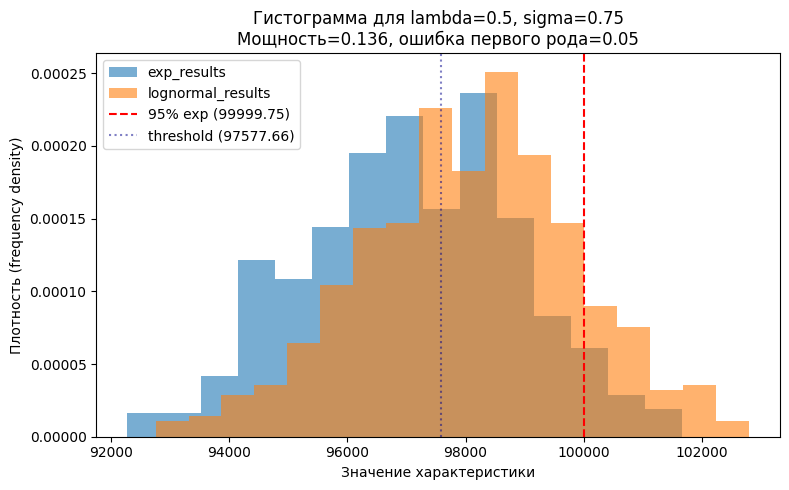

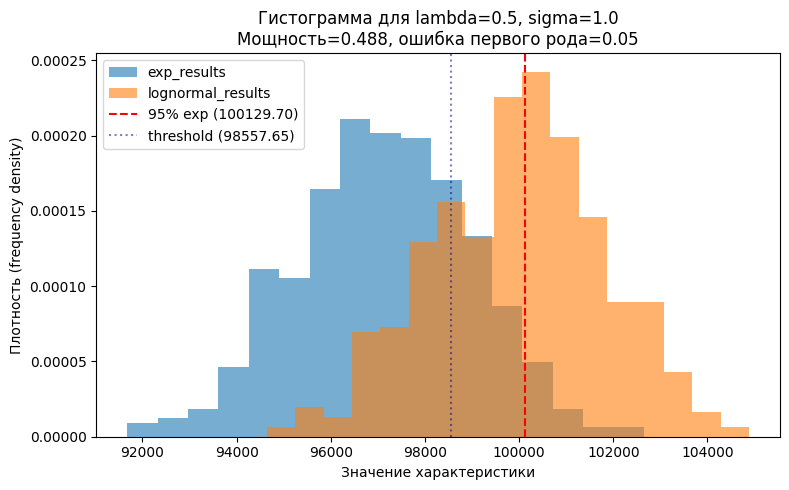

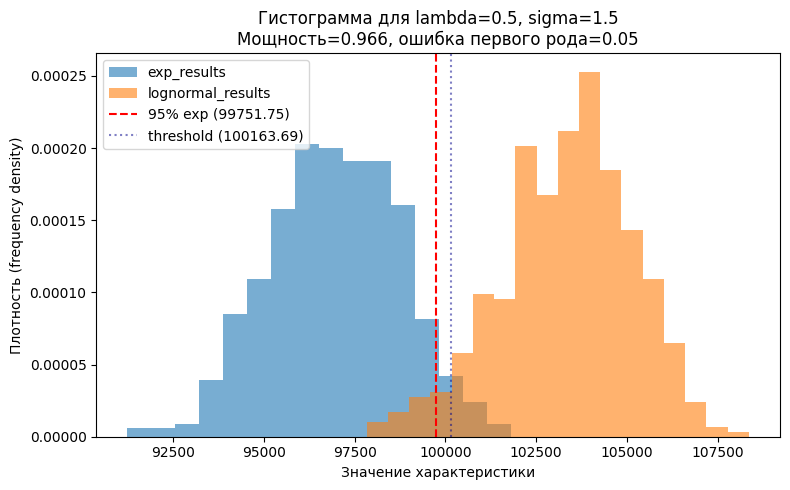

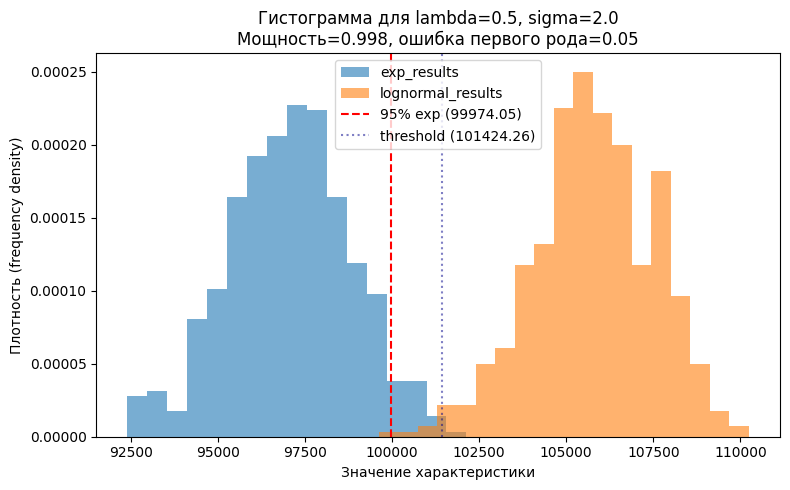

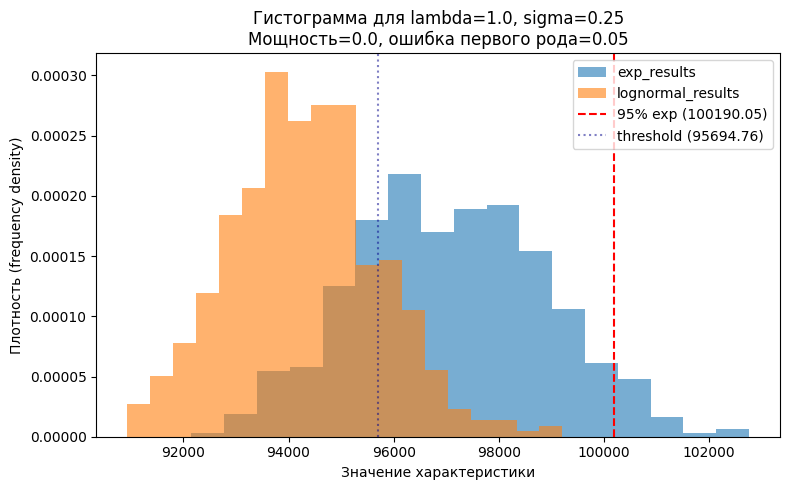

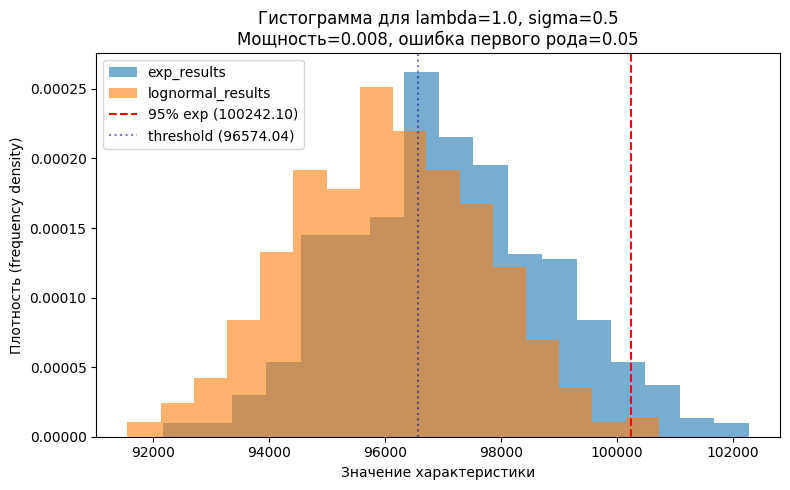

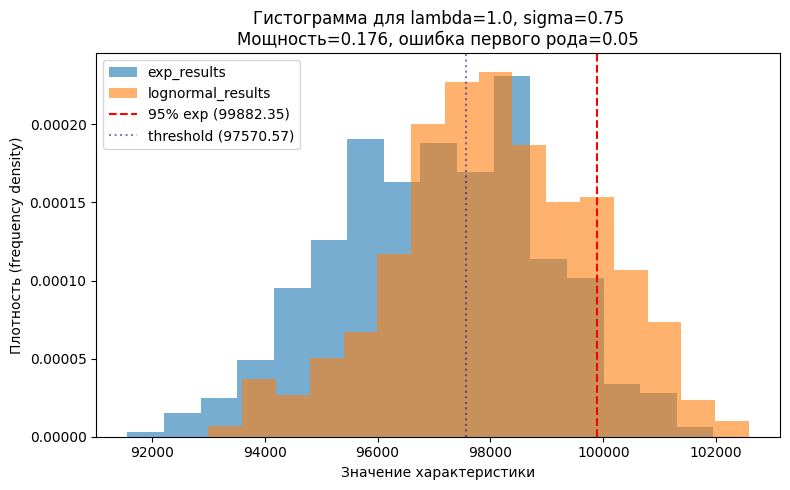

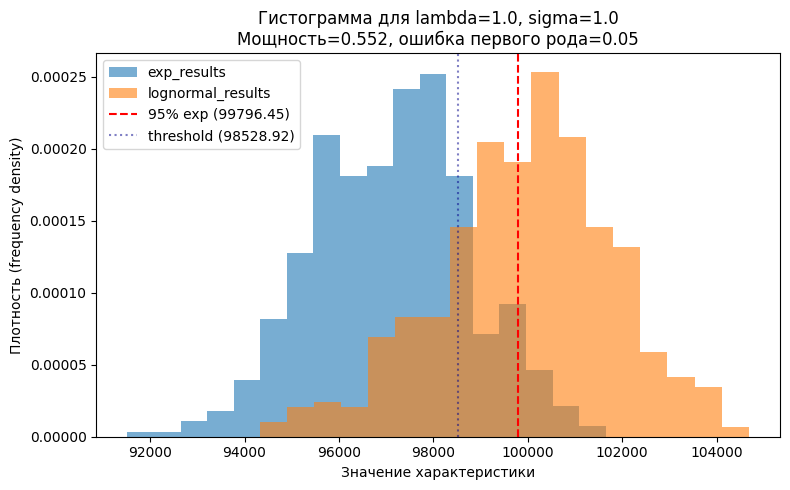

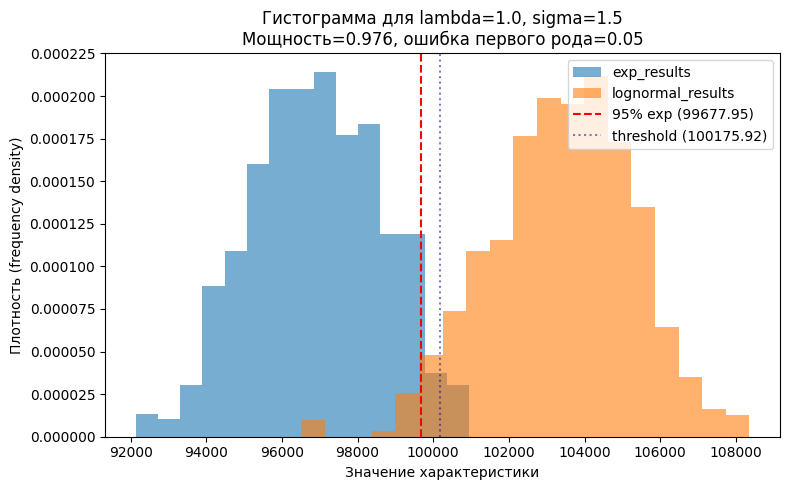

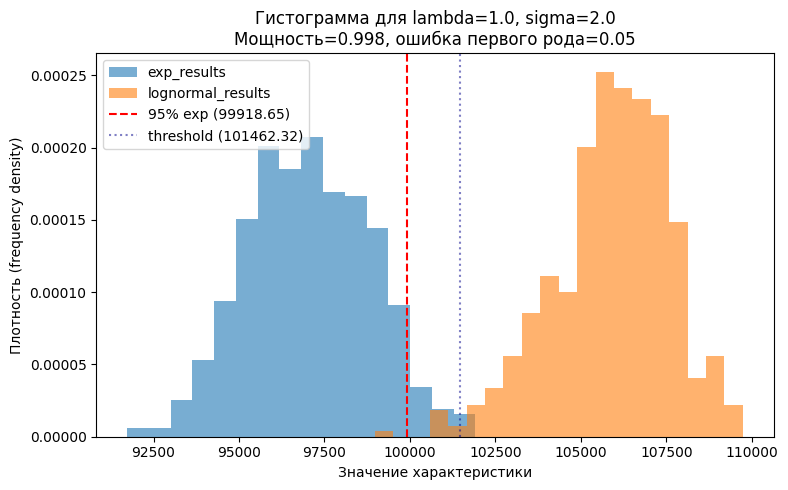

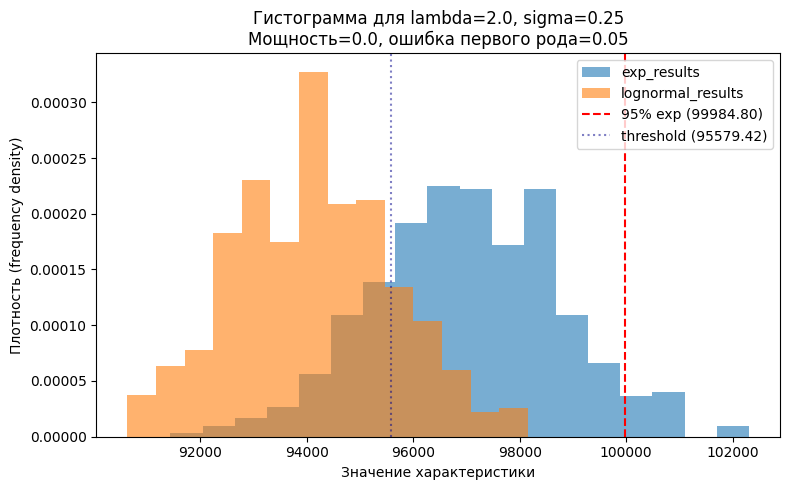

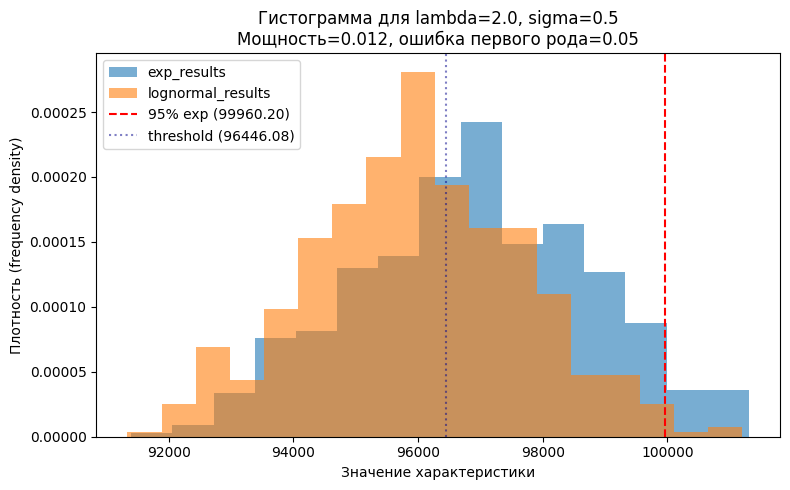

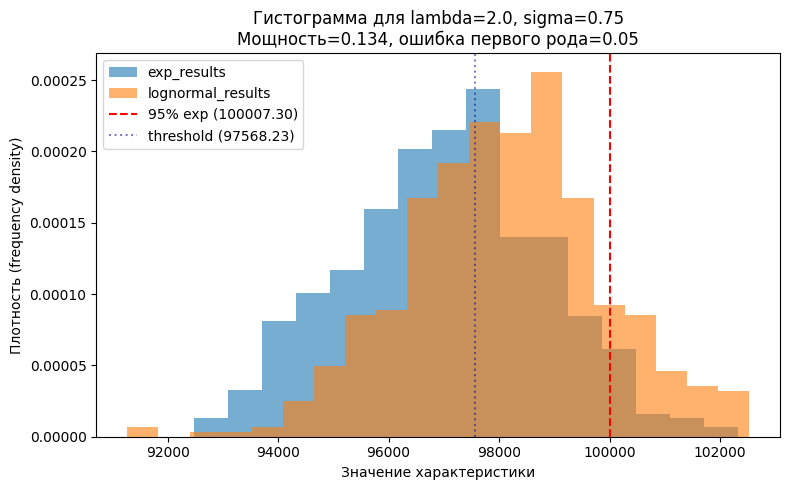

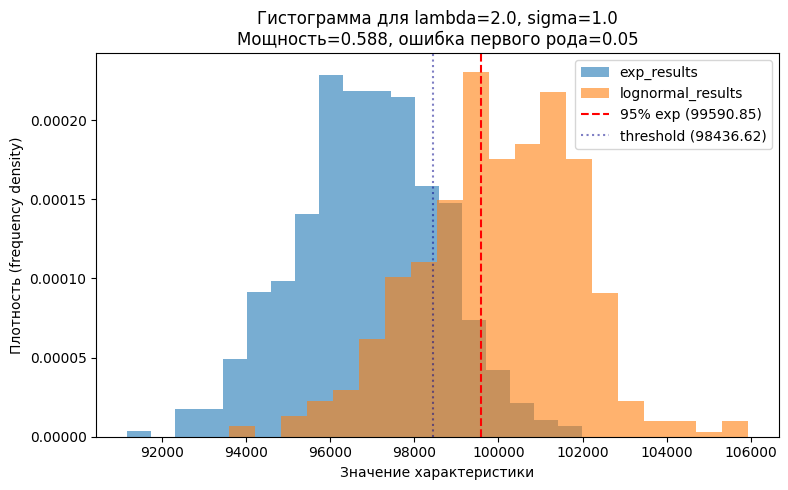

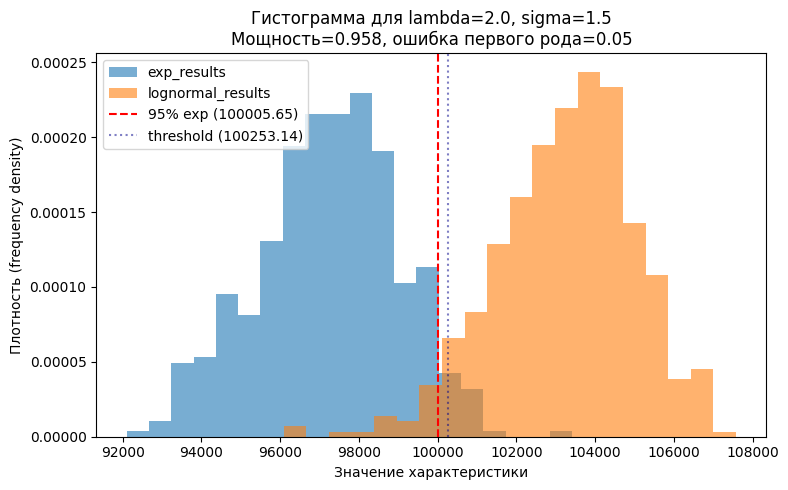

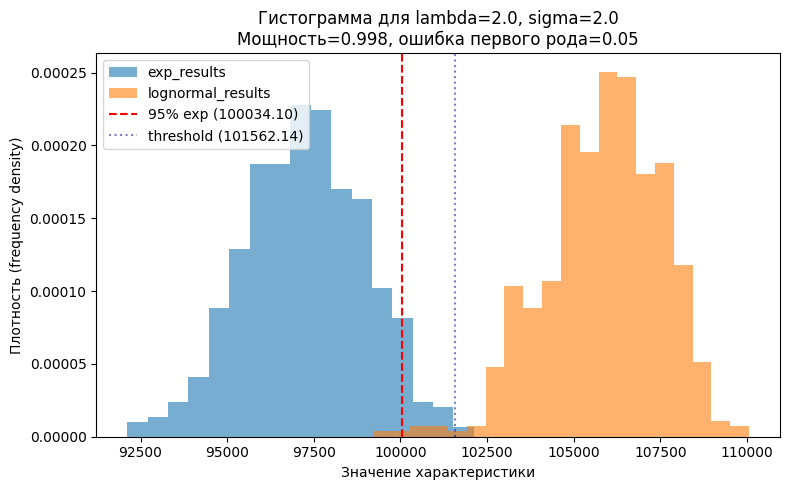

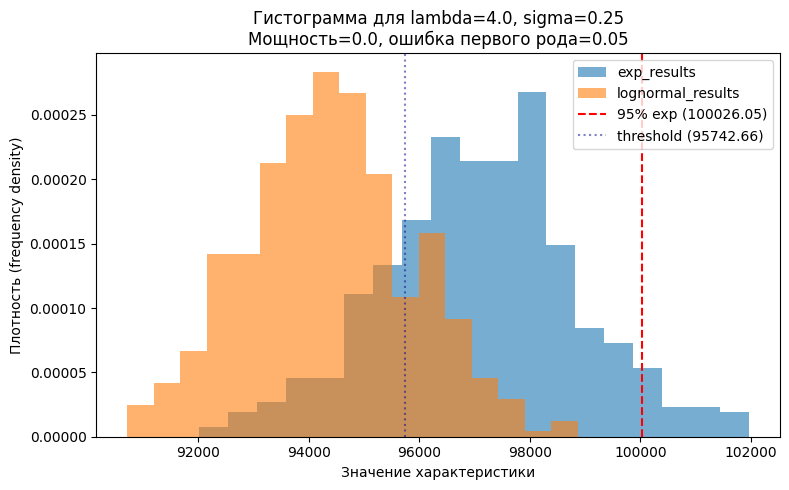

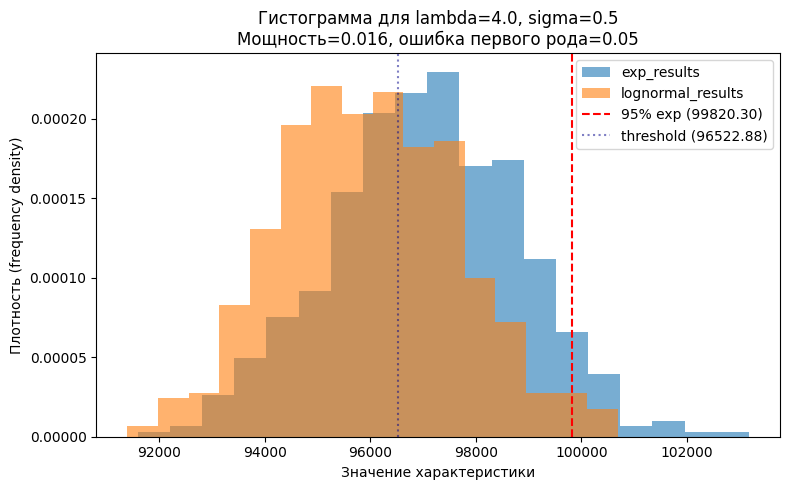

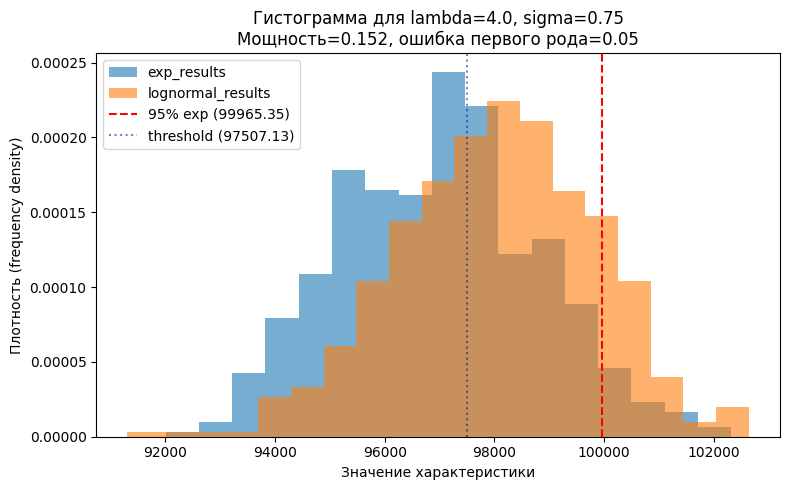

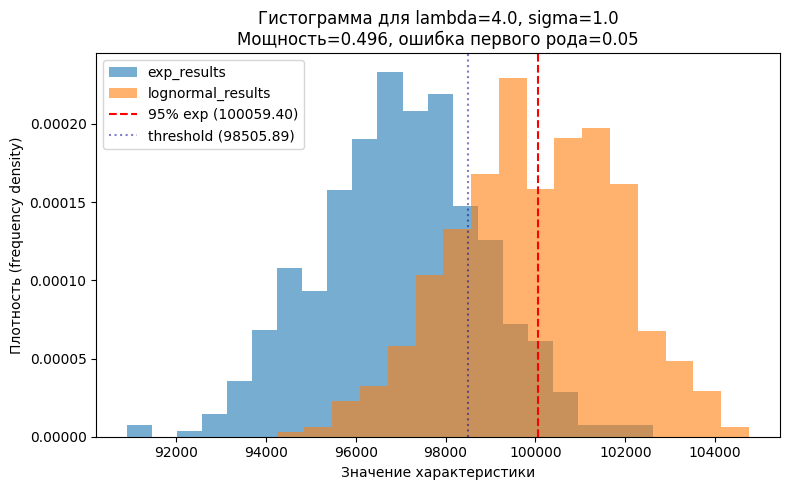

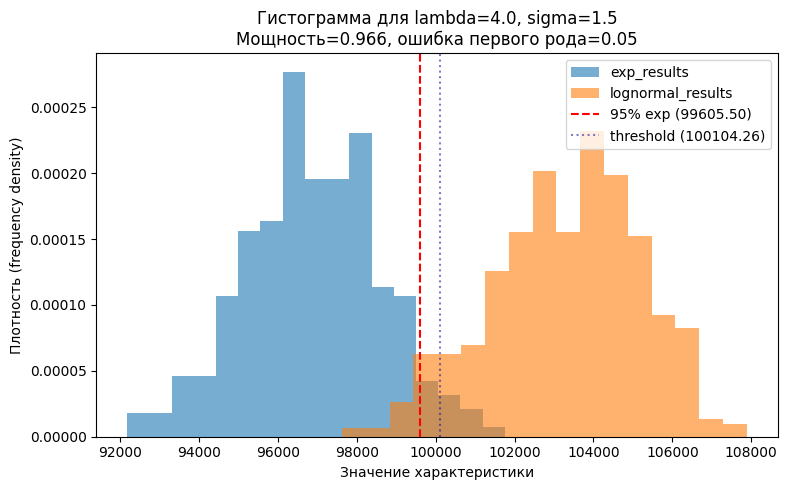

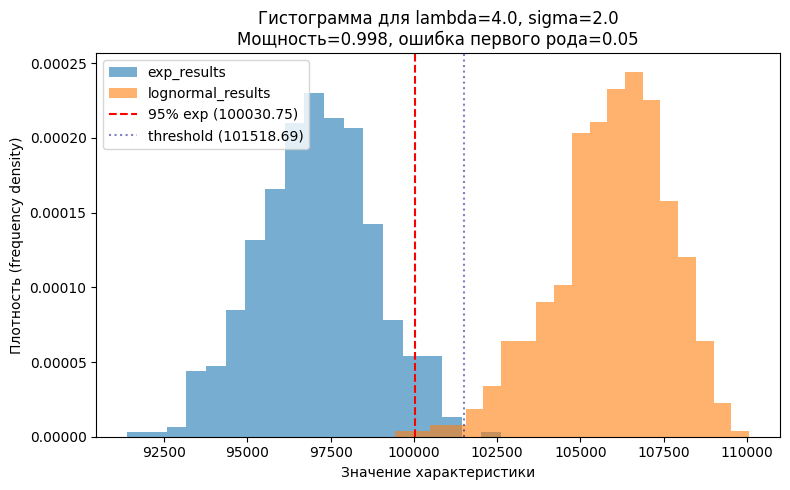

In [192]:
metrics_knn = []

for lam in lam_array:
    for sigma in sigma_array:
        exp_results = monte_carlo_multiprocessing(M, n, lam, k, generate_exp, build_knn_graph, num_triangles)
        lognormal_results = monte_carlo_multiprocessing(M, n, sigma, k, generate_lognormal, build_knn_graph, num_triangles)
        metrics_knn.append(analyze_lam_sigma(lam, sigma, exp_results, lognormal_results))

df_metrics = pd.DataFrame(metrics_knn)

In [201]:
df_metrics[df_metrics['sigma'] == 1]

lambda  sigma  power  alpha    p95_exp  threshold   mean_exp  \
3     0.10    1.0  0.544   0.05   99957.80  98560.053  97062.222   
9     0.25    1.0  0.568   0.05   99892.55  98545.408  97089.126   
15    0.50    1.0  0.488   0.05  100129.70  98557.650  97140.834   
21    1.00    1.0  0.552   0.05   99796.45  98528.924  97113.032   
27    2.00    1.0  0.588   0.05   99590.85  98436.617  96887.448   
33    4.00    1.0  0.496   0.05  100059.40  98505.888  97007.818   

         var_exp      std_exp     se_exp    mean_log       var_log  \
3   3.295397e+06  1815.322917  81.183709  100057.884  3.586137e+06   
9   3.064033e+06  1750.437984  78.281966  100001.690  3.672292e+06   
15  3.398811e+06  1843.586355  82.447688   99974.466  3.333682e+06   
21  2.746138e+06  1657.147681  74.109897   99944.816  3.504055e+06   
27  2.951600e+06  1718.022148  76.832286   99985.786  3.534567e+06   
33  3.388179e+06  1840.700744  82.318640  100003.958  3.342382e+06   

        std_log     se_log  
3   1893.709899  84.689281  
9   1916.322561  85.700550  
15  1825.837398  81.653931  
21  1871.912048  83.714452  
27  1880.044287  84.078137  
33  1828.218306  81.760408

In [202]:
df_metrics[df_metrics['lambda'] == 0.5]

lambda  sigma  power  alpha    p95_exp   threshold   mean_exp  \
12     0.5   0.25  0.000   0.05   99995.20   95627.742  96976.320   
13     0.5   0.50  0.012   0.05   99977.80   96555.815  97023.964   
14     0.5   0.75  0.136   0.05   99999.75   97577.659  97085.852   
15     0.5   1.00  0.488   0.05  100129.70   98557.650  97140.834   
16     0.5   1.50  0.966   0.05   99751.75  100163.689  96969.030   
17     0.5   2.00  0.998   0.05   99974.05  101424.260  97064.870   

         var_exp      std_exp     se_exp    mean_log       var_log  \
12  3.111887e+06  1764.054210  78.890903   94279.164  2.169405e+06   
13  3.093950e+06  1758.962621  78.663200   96087.666  2.972265e+06   
14  3.236369e+06  1798.991159  80.453330   98069.466  3.338250e+06   
15  3.398811e+06  1843.586355  82.447688   99974.466  3.333682e+06   
16  3.247184e+06  1801.994446  80.587642  103358.348  3.286155e+06   
17  3.098506e+06  1760.257441  78.721106  105783.650  2.968276e+06   

        std_log     se_log  
12  1472.890142  65.869650  
13  1724.025753  77.100776  
14  1827.087861  81.709853  
15  1825.837398  81.653931  
16  1812.775544  81.069787  
17  1722.868615  77.049027

In [203]:
df_metrics

lambda  sigma  power  alpha    p95_exp   threshold   mean_exp  \
0     0.10   0.25  0.000   0.05   99942.40   95680.450  97133.544   
1     0.10   0.50  0.004   0.05  100093.65   96557.507  97105.620   
2     0.10   0.75  0.156   0.05  100195.40   97696.040  97174.292   
3     0.10   1.00  0.544   0.05   99957.80   98560.053  97062.222   
4     0.10   1.50  0.956   0.05   99964.20  100207.329  97081.372   
5     0.10   2.00  0.998   0.05  100020.30  101535.197  97057.388   
6     0.25   0.25  0.000   0.05  100228.40   95666.719  97080.262   
7     0.25   0.50  0.022   0.05   99653.95   96594.182  97072.670   
8     0.25   0.75  0.138   0.05  100002.95   97563.149  97153.900   
9     0.25   1.00  0.568   0.05   99892.55   98545.408  97089.126   
10    0.25   1.50  0.950   0.05   99859.45  100232.618  97181.558   
11    0.25   2.00  0.996   0.05  100293.60  101541.918  97225.064   
12    0.50   0.25  0.000   0.05   99995.20   95627.742  96976.320   
13    0.50   0.50  0.012   0.05   99977.80   96555.815  97023.964   
14    0.50   0.75  0.136   0.05   99999.75   97577.659  97085.852   
15    0.50   1.00  0.488   0.05  100129.70   98557.650  97140.834   
16    0.50   1.50  0.966   0.05   99751.75  100163.689  96969.030   
17    0.50   2.00  0.998   0.05   99974.05  101424.260  97064.870   
18    1.00   0.25  0.000   0.05  100190.05   95694.757  97076.392   
19    1.00   0.50  0.008   0.05  100242.10   96574.038  97093.986   
20    1.00   0.75  0.176   0.05   99882.35   97570.570  97053.550   
21    1.00   1.00  0.552   0.05   99796.45   98528.924  97113.032   
22    1.00   1.50  0.976   0.05   99677.95  100175.918  96953.552   
23    1.00   2.00  0.998   0.05   99918.65  101462.316  97041.554   
24    2.00   0.25  0.000   0.05   99984.80   95579.423  97023.856   
25    2.00   0.50  0.012   0.05   99960.20   96446.081  96907.554   
26    2.00   0.75  0.134   0.05  100007.30   97568.228  97046.564   
27    2.00   1.00  0.588   0.05   99590.85   98436.617  96887.448   
28    2.00   1.50  0.958   0.05  100005.65  100253.143  97243.966   
29    2.00   2.00  0.998   0.05  100034.10  101562.141  97253.710   
30    4.00   0.25  0.000   0.05  100026.05   95742.663  97106.800   
31    4.00   0.50  0.016   0.05   99820.30   96522.885  97045.264   
32    4.00   0.75  0.152   0.05   99965.35   97507.132  96990.730   
33    4.00   1.00  0.496   0.05  100059.40   98505.888  97007.818   
34    4.00   1.50  0.966   0.05   99605.50  100104.264  96893.808   
35    4.00   2.00  0.998   0.05  100030.75  101518.693  97081.882   

         var_exp      std_exp     se_exp    mean_log       var_log  \
0   3.126898e+06  1768.303681  79.080945   94227.356  2.192954e+06   
1   3.449632e+06  1857.318594  83.061813   96009.394  2.693396e+06   
2   2.962087e+06  1721.071448  76.968655   98217.788  3.395097e+06   
3   3.295397e+06  1815.322917  81.183709  100057.884  3.586137e+06   
4   3.174198e+06  1781.627988  79.676826  103333.286  3.461529e+06   
5   3.208943e+06  1791.352179  80.111705  106013.006  2.744492e+06   
6   3.220942e+06  1794.698220  80.261344   94253.176  2.345097e+06   
7   2.990459e+06  1729.294374  77.336395   96115.694  2.701755e+06   
8   3.334301e+06  1826.006820  81.661508   97972.398  3.080264e+06   
9   3.064033e+06  1750.437984  78.281966  100001.690  3.672292e+06   
10  2.941159e+06  1714.980745  76.696271  103283.678  3.698049e+06   
11  3.202886e+06  1789.660940  80.036070  105858.772  2.578263e+06   
12  3.111887e+06  1764.054210  78.890903   94279.164  2.169405e+06   
13  3.093950e+06  1758.962621  78.663200   96087.666  2.972265e+06   
14  3.236369e+06  1798.991159  80.453330   98069.466  3.338250e+06   
15  3.398811e+06  1843.586355  82.447688   99974.466  3.333682e+06   
16  3.247184e+06  1801.994446  80.587642  103358.348  3.286155e+06   
17  3.098506e+06  1760.257441  78.721106  105783.650  2.968276e+06   
18  3.293215e+06  1814.721800  81.156826   94313.122  2.011747e+06   
19  3.198574e+06  1788.455886  79.982179   96054.0

**Вывод:**
* $\lambda$ особо не влияет на характеристику knn-графа, при фиксированном $\sigma$ и изменении $\lambda$ метрики качества остаются примерно равными.
* $\sigma$ довольно сильно влият на результат, чем больше $\sigma$, тем "левее" значения $Exp(\lambda)$ и "правее" значения $LogNormal(0, \sigma) \Rightarrow$ мы можем классифицировать их с большей точностью.

#### Исследуем дистанционный-граф

In [204]:
n = 100
k = int(2 * n / 3)
d = 0.8

In [205]:
lam_array = [0.1, 0.25, 0.5, 1.0, 2.0, 4.0]
sigma_array = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0]

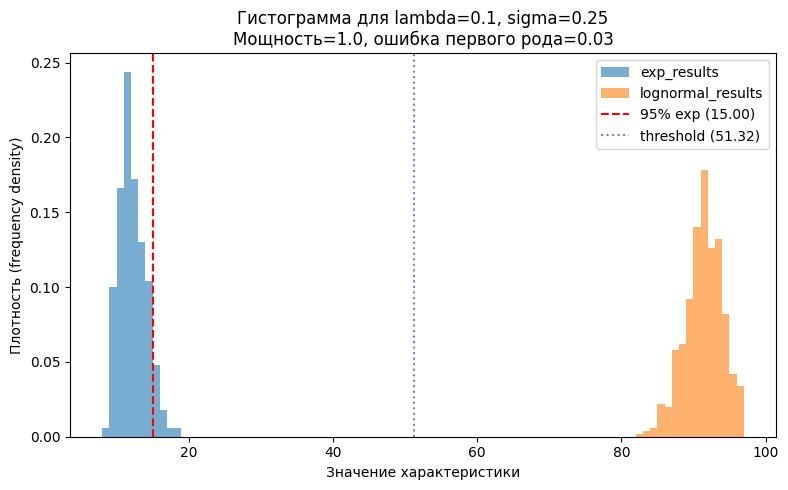

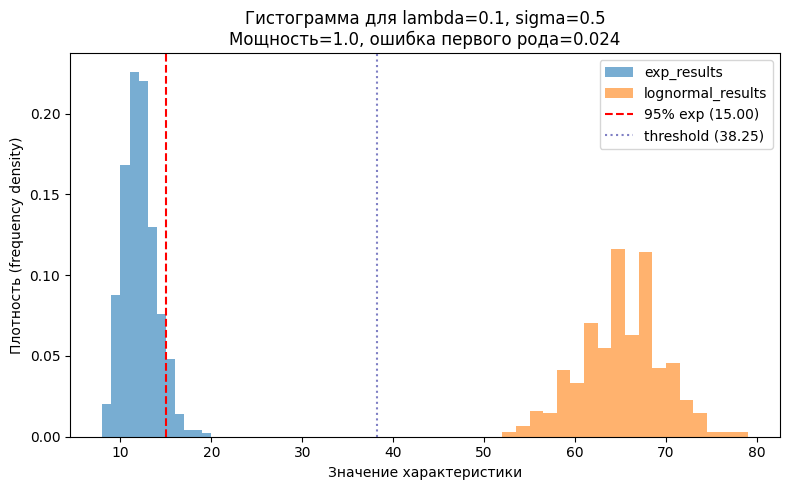

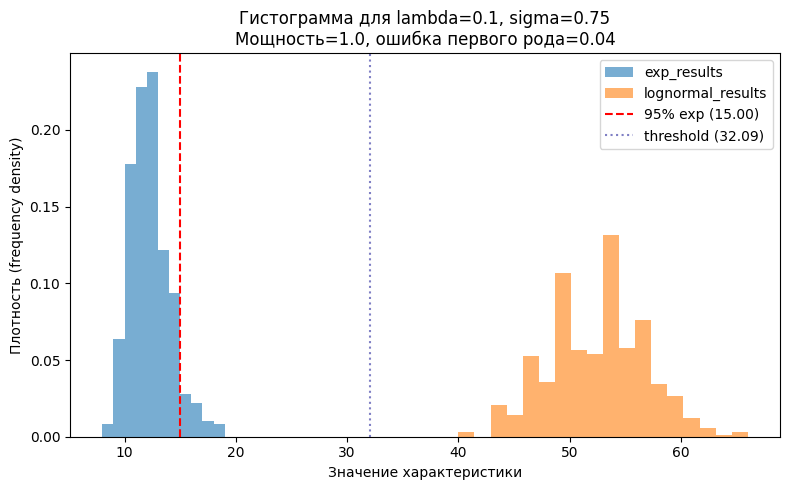

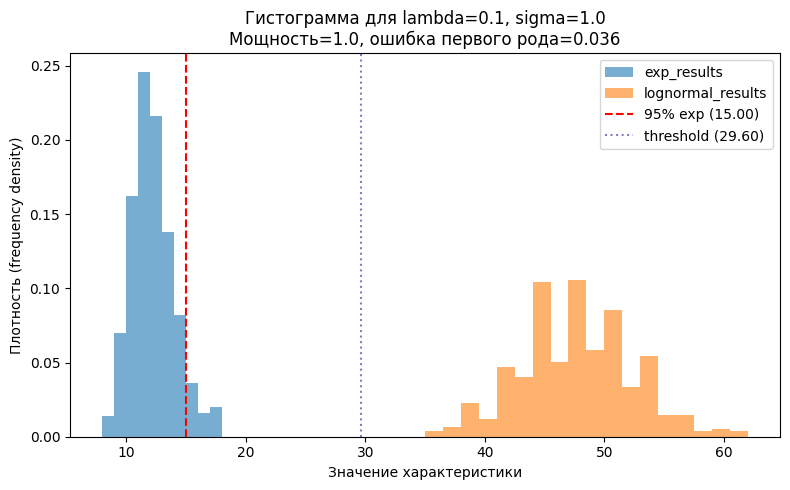

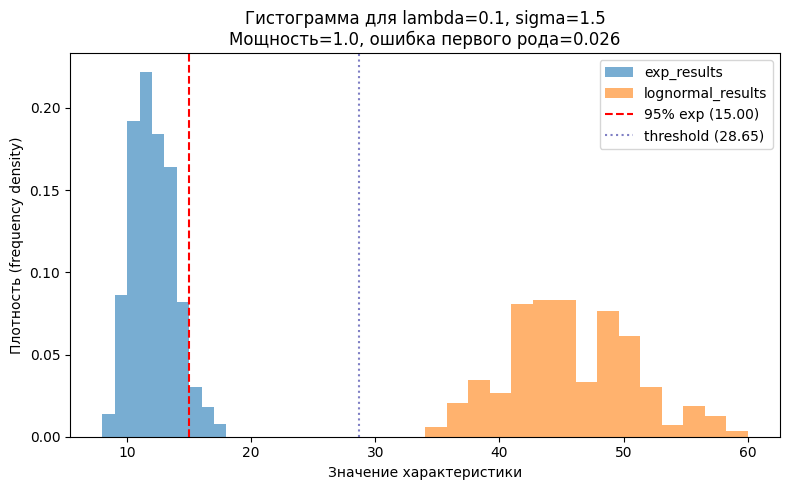

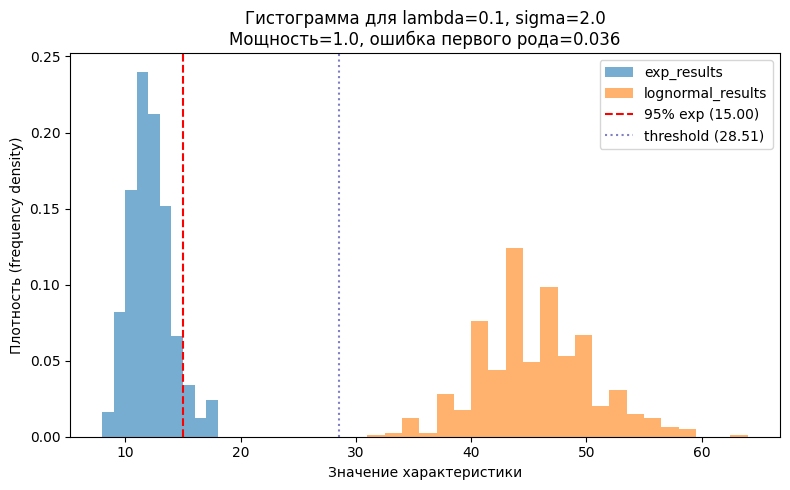

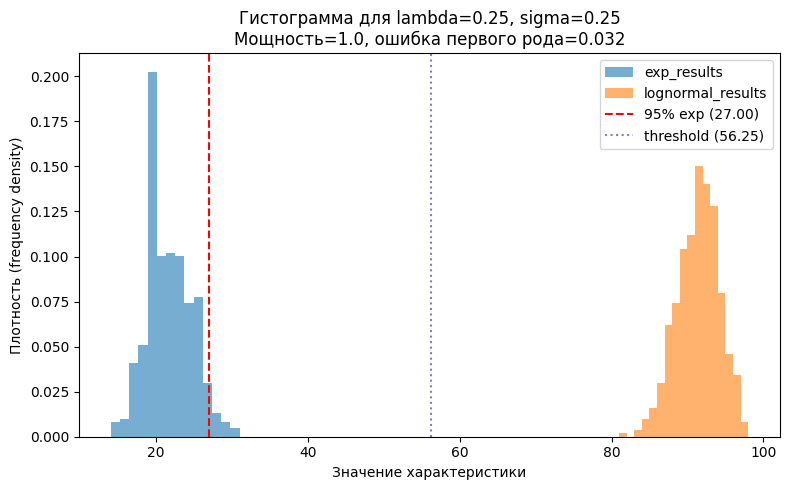

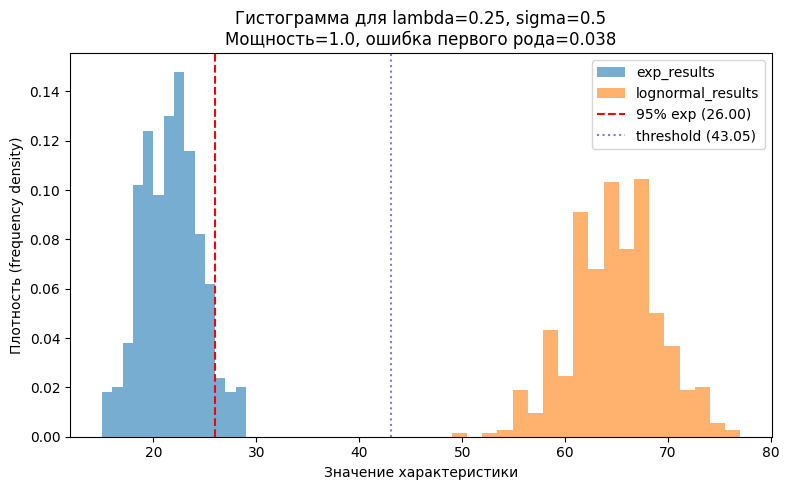

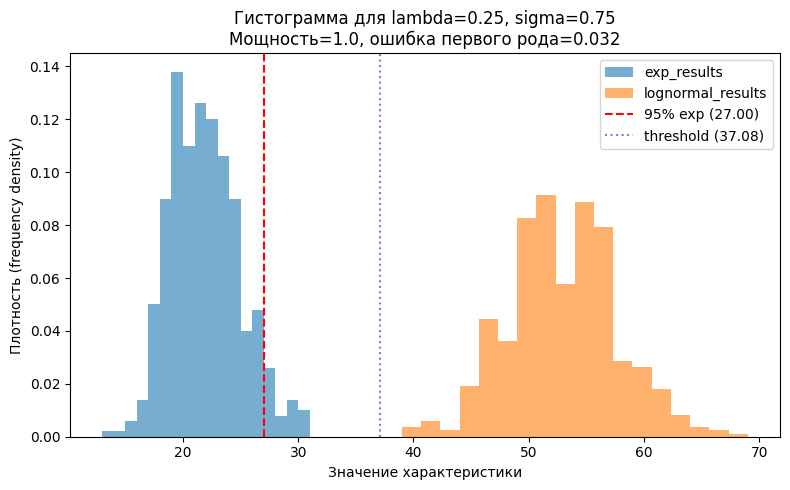

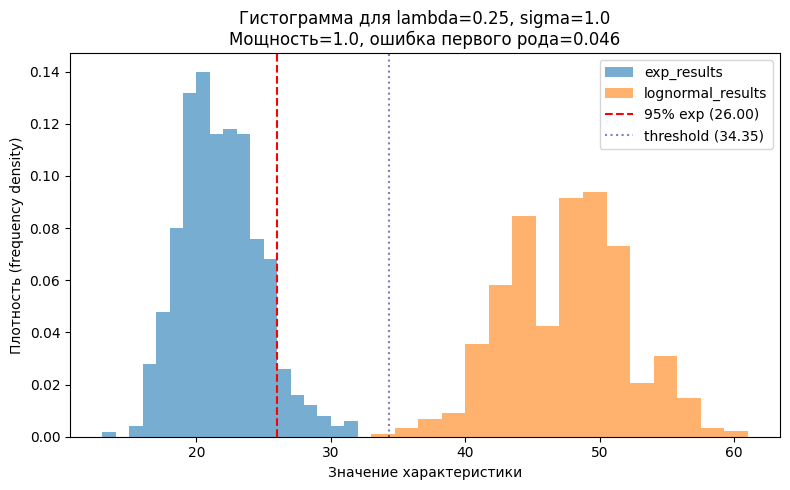

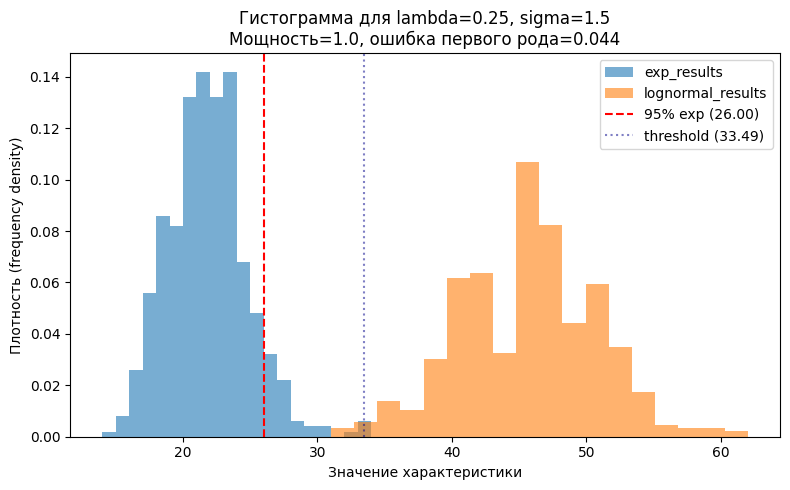

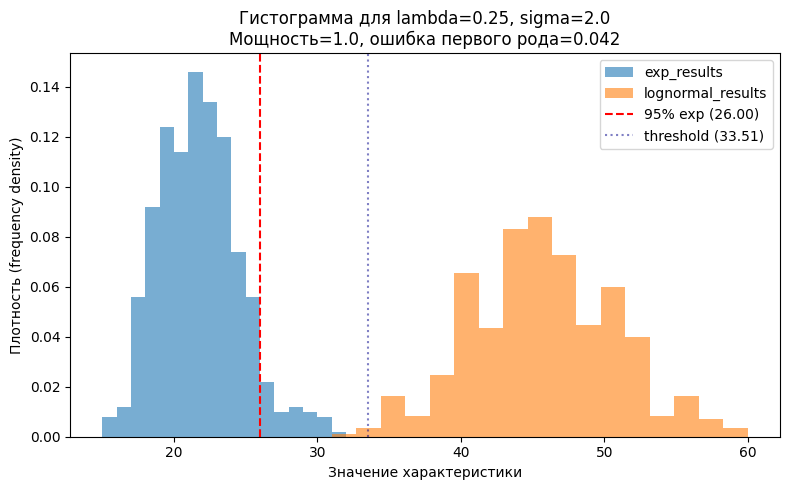

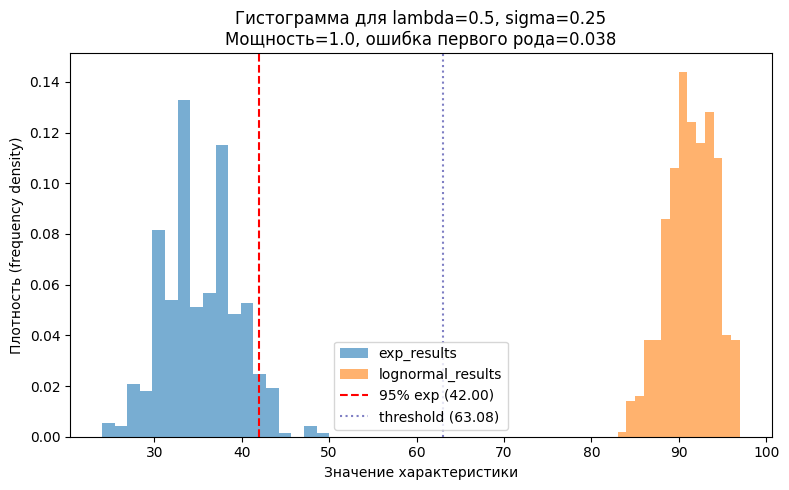

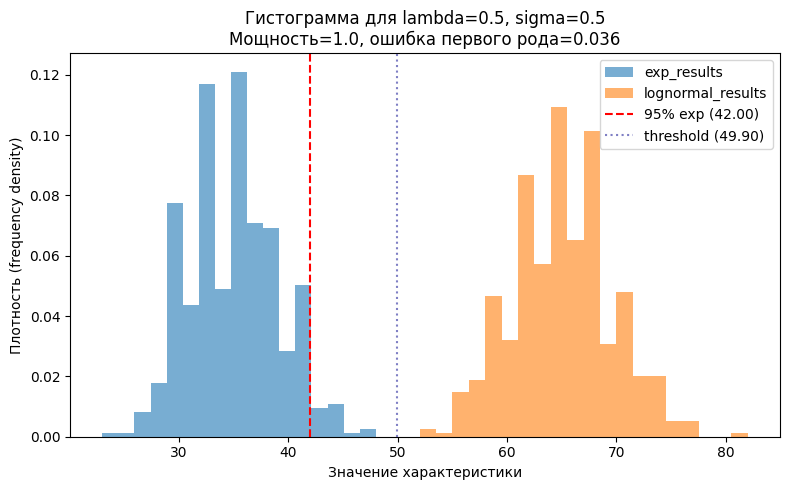

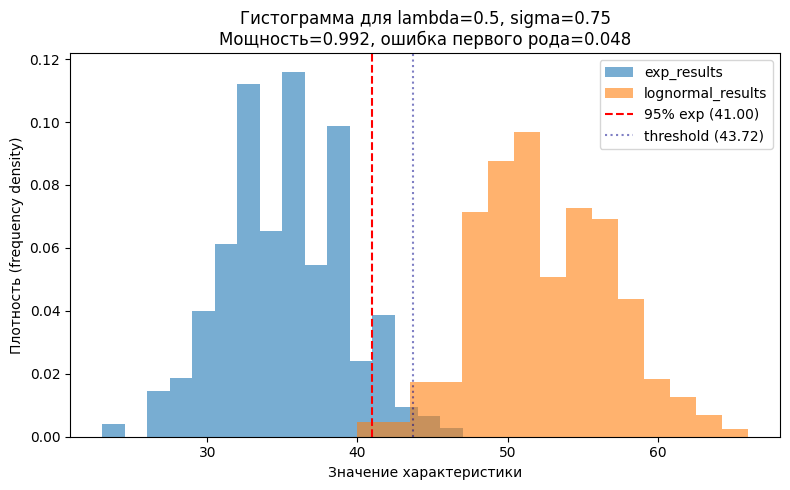

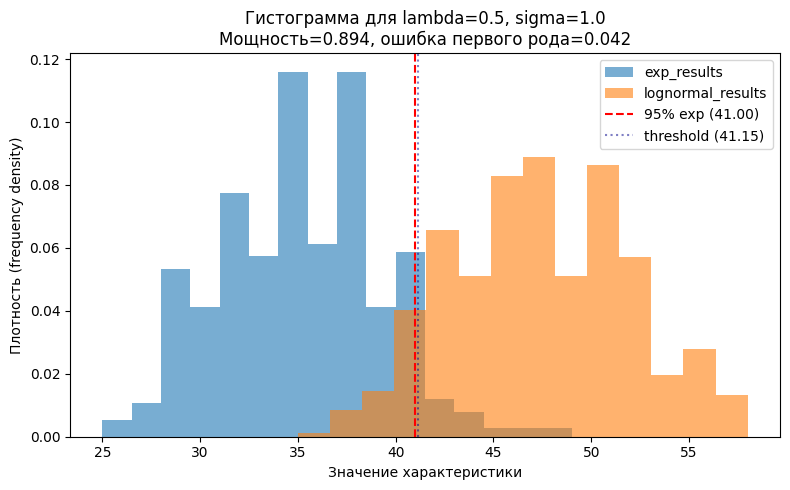

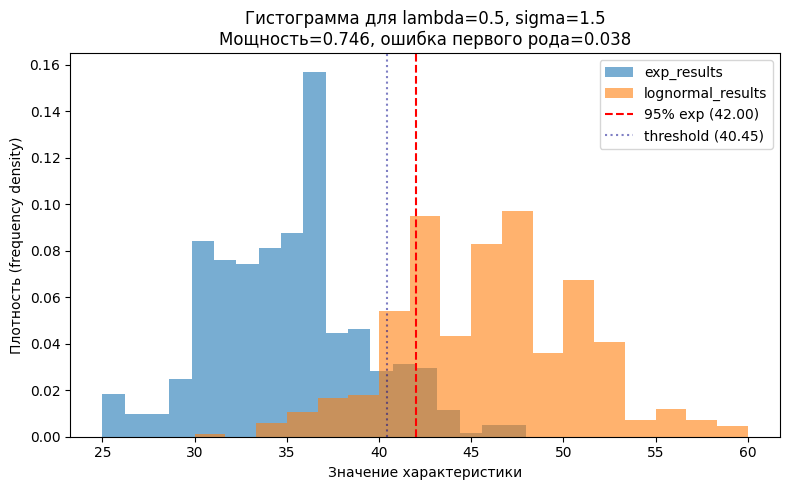

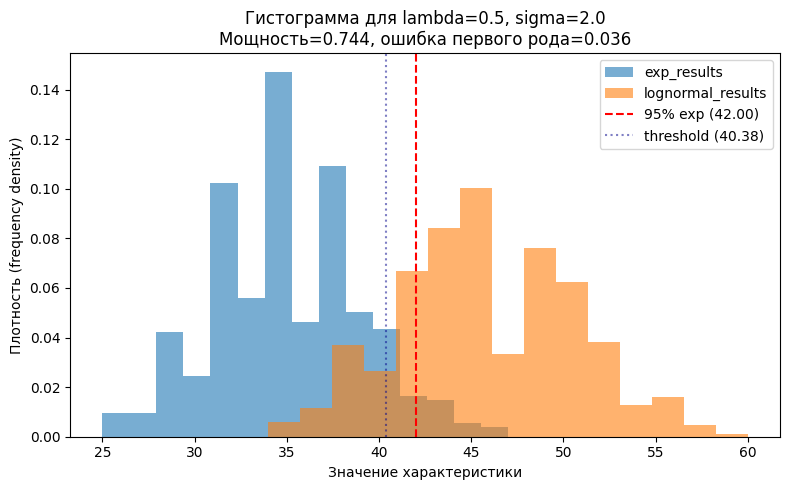

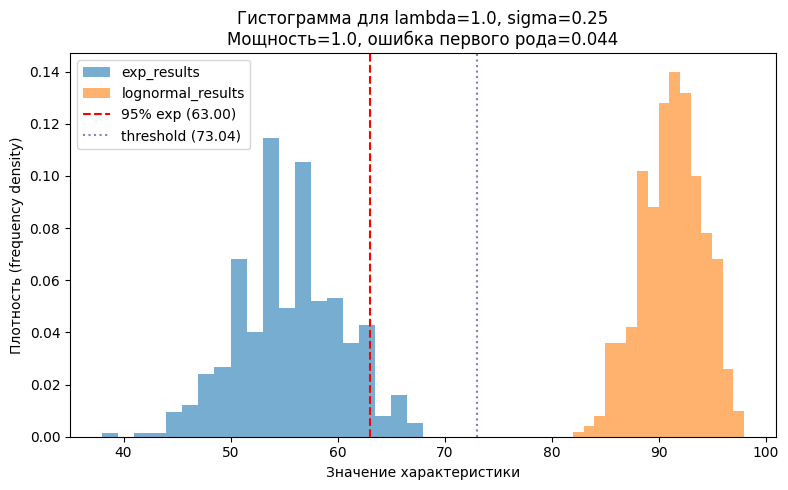

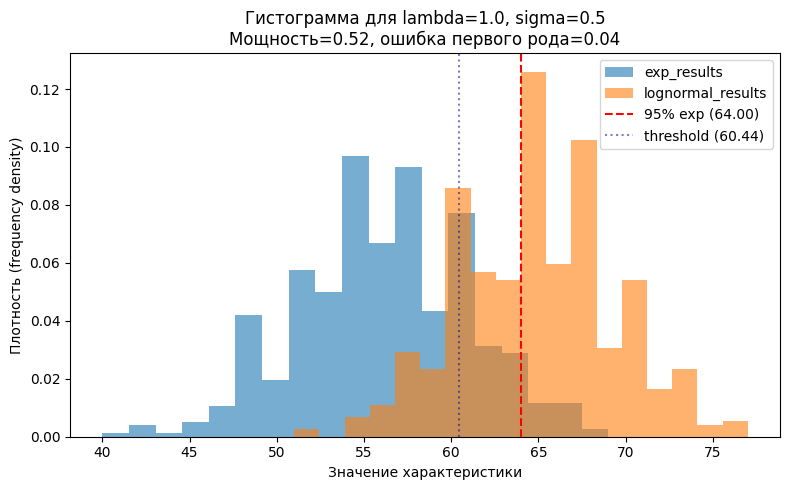

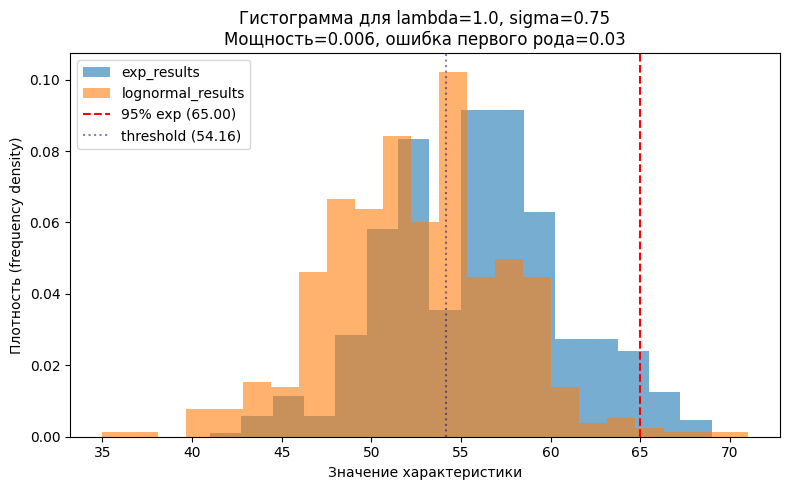

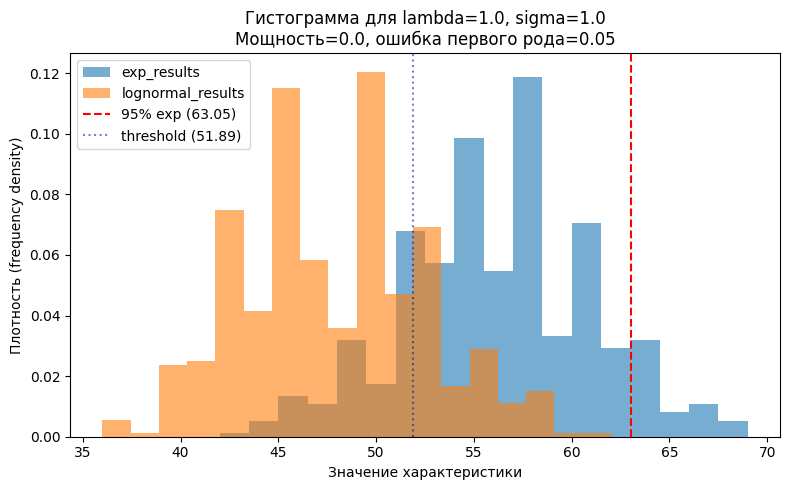

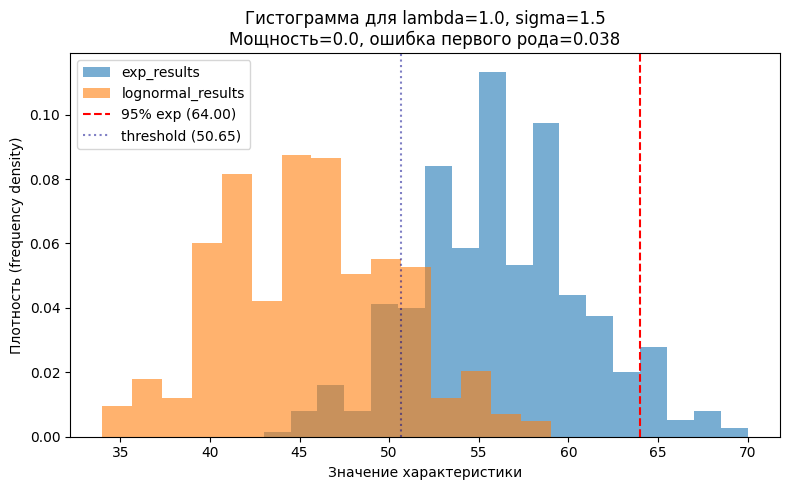

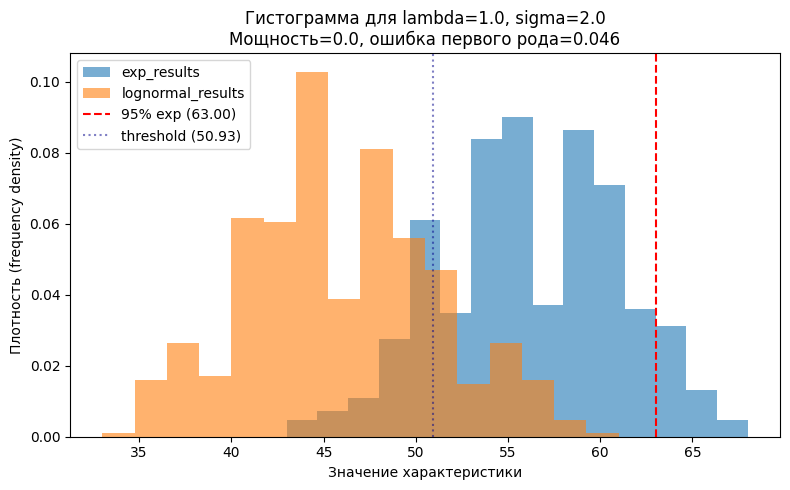

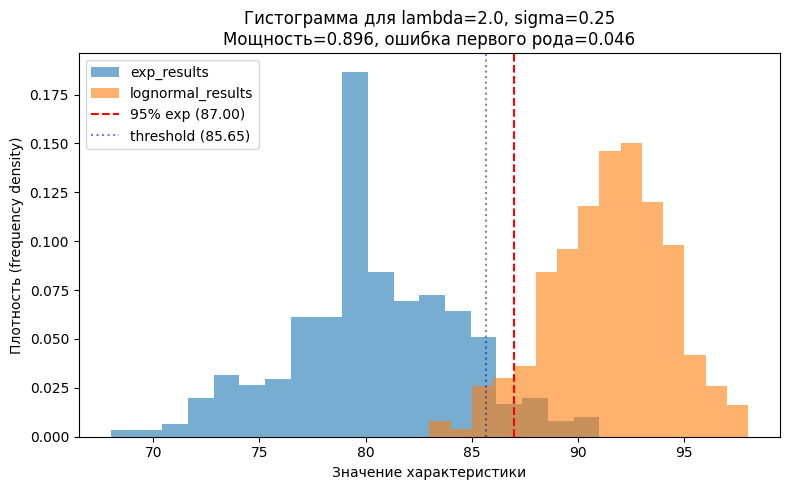

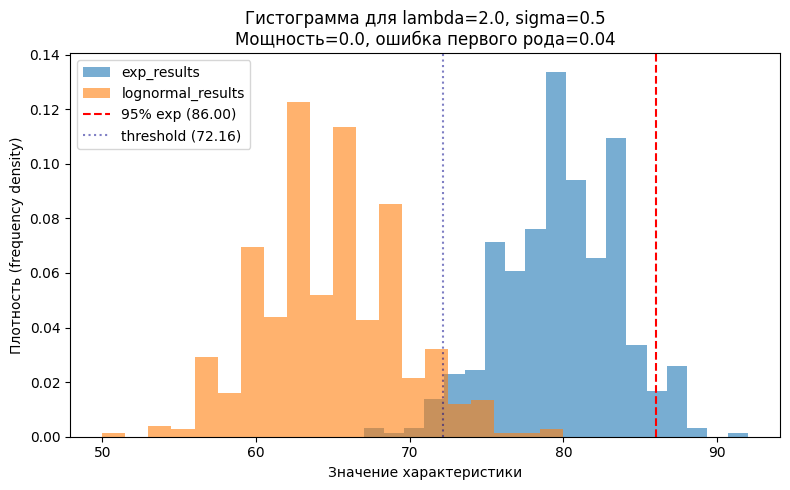

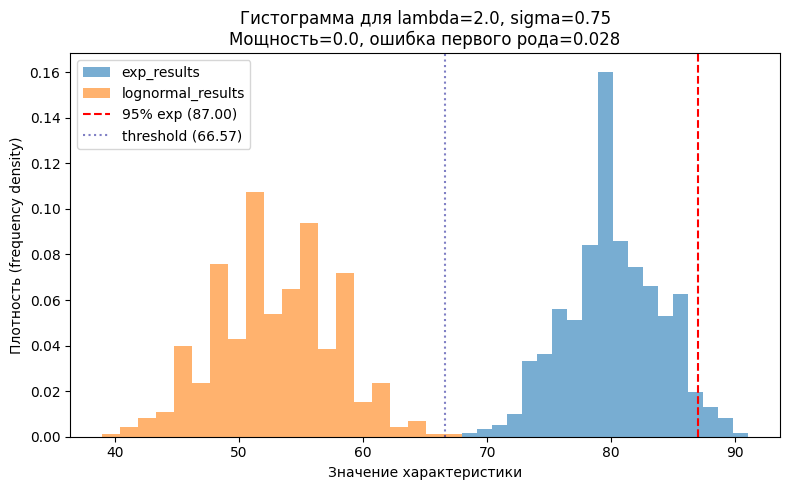

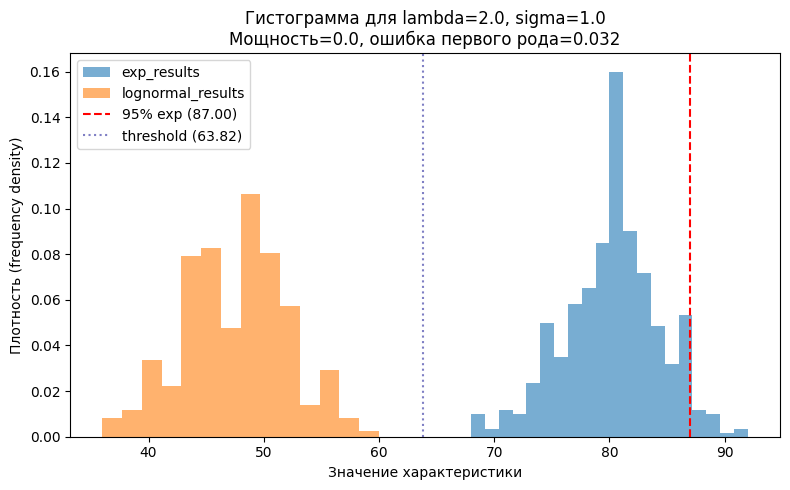

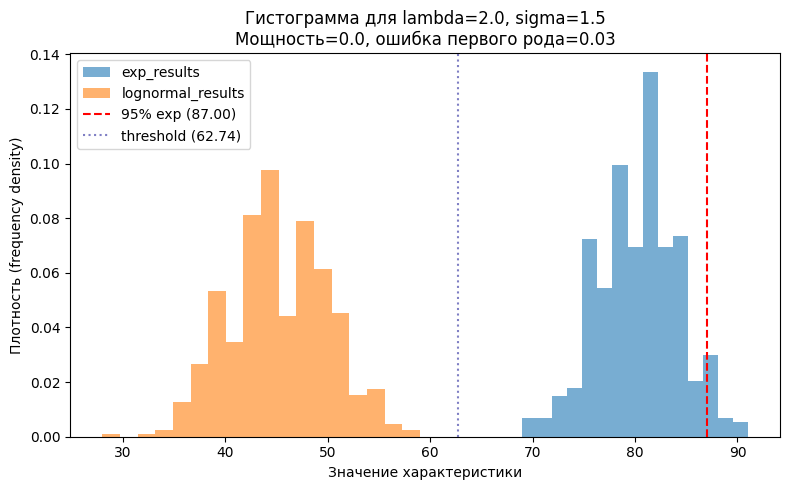

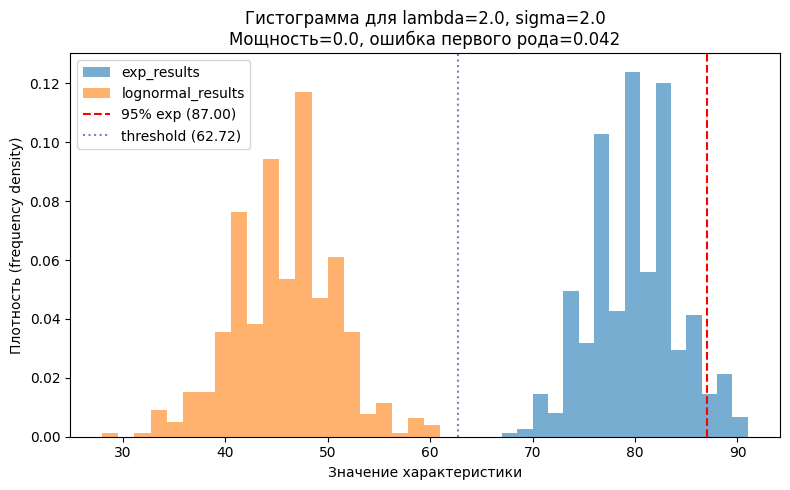

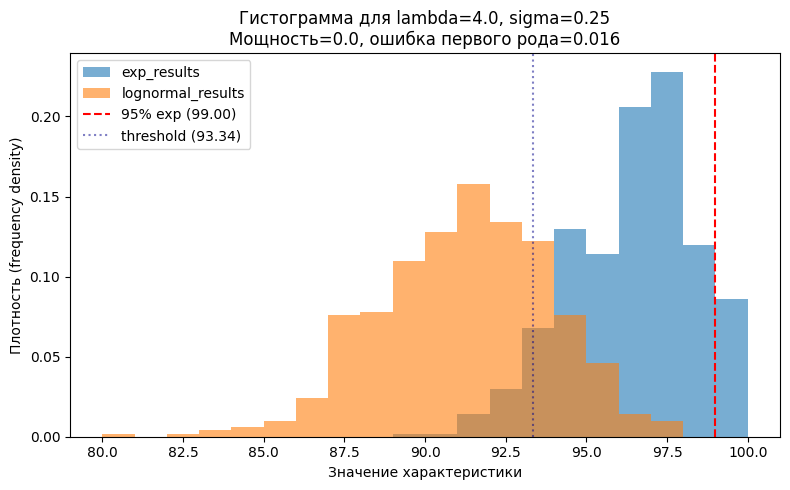

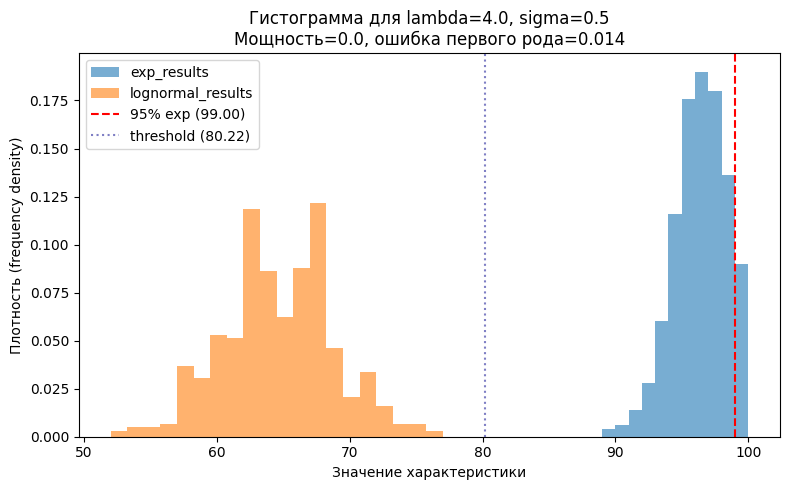

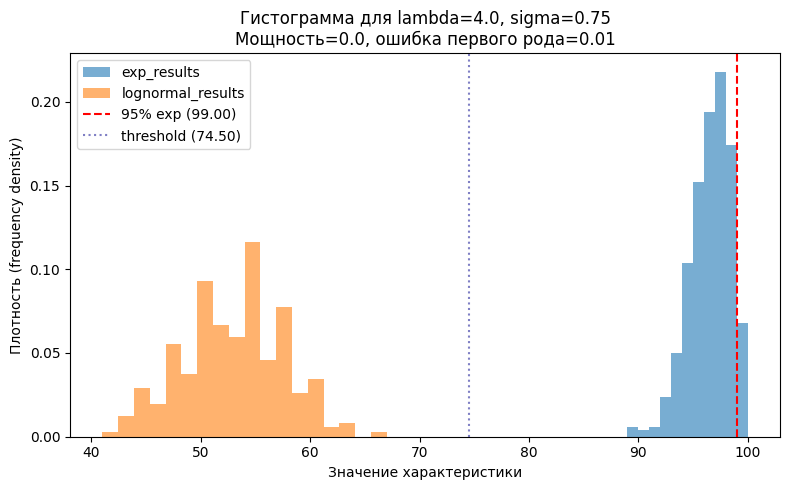

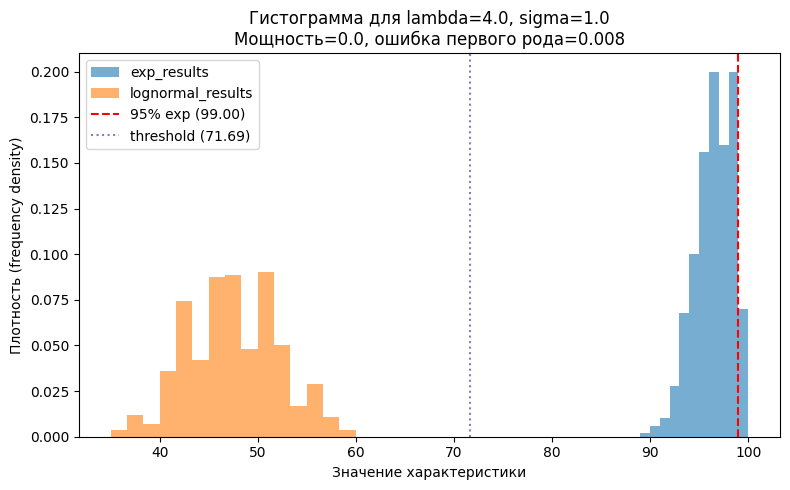

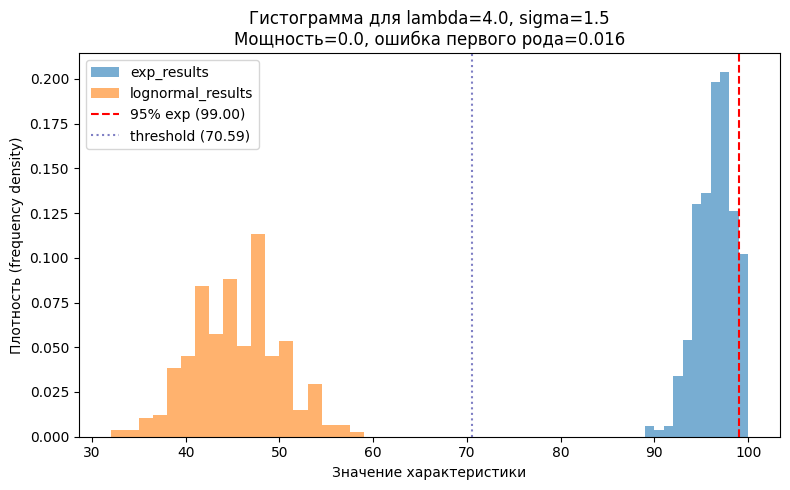

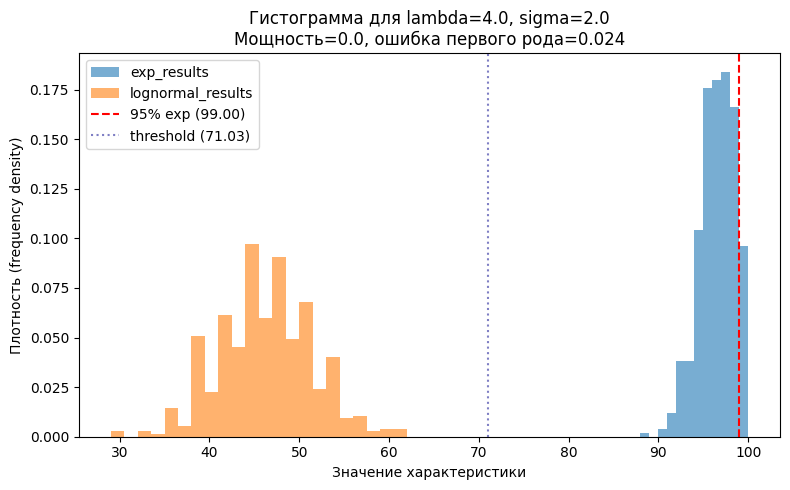

In [206]:
metrics_dist = []

for lam in lam_array:
    for sigma in sigma_array:
        exp_results = monte_carlo_multiprocessing(M, n, lam, d, generate_exp, build_distance_graph, get_clique_number)
        lognormal_results = monte_carlo_multiprocessing(M, n, sigma, d, generate_lognormal, build_distance_graph, get_clique_number)
        metrics_dist.append(analyze_lam_sigma(lam, sigma, exp_results, lognormal_results))

df_metrics = pd.DataFrame(metrics_dist)       

In [207]:
df_metrics

lambda  sigma  power  alpha  p95_exp  threshold  mean_exp    var_exp  \
0     0.10   0.25  1.000  0.030    15.00     51.317    11.724   3.518862   
1     0.10   0.50  1.000  0.024    15.00     38.247    11.636   3.346196   
2     0.10   0.75  1.000  0.040    15.00     32.094    11.774   3.265455   
3     0.10   1.00  1.000  0.036    15.00     29.603    11.740   3.254910   
4     0.10   1.50  1.000  0.026    15.00     28.651    11.614   3.139283   
5     0.10   2.00  1.000  0.036    15.00     28.509    11.686   3.370144   
6     0.25   0.25  1.000  0.032    27.00     56.254    21.626   8.763651   
7     0.25   0.50  1.000  0.038    26.00     43.049    21.234   7.858962   
8     0.25   0.75  1.000  0.032    27.00     37.081    21.430   9.239579   
9     0.25   1.00  1.000  0.046    26.00     34.352    21.308   8.738613   
10    0.25   1.50  1.000  0.044    26.00     33.487    21.342   8.818673   
11    0.25   2.00  1.000  0.042    26.00     33.507    21.278   8.064846   
12    0.50   0.25  1.000  0.038    42.00     63.079    35.256  17.377218   
13    0.50   0.50  1.000  0.036    42.00     49.903    34.982  16.795267   
14    0.50   0.75  0.992  0.048    41.00     43.722    34.926  15.920365   
15    0.50   1.00  0.894  0.042    41.00     41.149    34.934  16.691026   
16    0.50   1.50  0.746  0.038    42.00     40.445    35.034  16.714273   
17    0.50   2.00  0.744  0.036    42.00     40.380    34.970  16.321743   
18    1.00   0.25  1.000  0.044    63.00     73.038    55.322  23.749816   
19    1.00   0.50  0.520  0.040    64.00     60.441    56.084  23.167279   
20    1.00   0.75  0.006  0.030    65.00     54.160    55.772  24.497010   
21    1.00   1.00  0.000  0.050    63.05     51.894    55.972  22.893002   
22    1.00   1.50  0.000  0.038    64.00     50.650    55.948  22.013323   
23    1.00   2.00  0.000  0.046    63.00     50.928    56.052  22.818934   
24    2.00   0.25  0.896  0.046    87.00     85.652    80.326  16.095916   
25    2.00   0.50  0.000  0.040    86.00     72.165    79.836  14.822749   
26    2.00   0.75  0.000  0.028    87.00     66.574    80.146  14.469623   
27    2.00   1.00  0.000  0.032    87.00     63.822    80.124  17.295214   
28    2.00   1.50  0.000  0.030    87.00     62.743    80.284  15.782910   
29    2.00   2.00  0.000  0.042    87.00     62.720    79.736  17.829964   
30    4.00   0.25  0.000  0.016    99.00     93.345    95.948   3.844986   
31    4.00   0.50  0.000  0.014    99.00     80.223    95.902   4.020437   
32    4.00   0.75  0.000  0.010    99.00     74.502    96.078   3.587090   
33    4.00   1.00  0.000  0.008    99.00     71.685    96.006   3.833631   
34    4.00   1.50  0.000  0.016    99.00     70.592    95.988   4.019896   
35    4.00   2.00  0.000  0.024    99.00     71.028    96.078   3.995908   

     std_exp    se_exp  mean_log    var_log   std_log    se_log  
0   1.875863  0.083891    90.910   6.939780  2.634346  0.117812  
1   1.829261  0.081807    64.858  20.049936  4.477715  0.200250  
2   1.807057  0.080814    52.414  18.211026  4.267438  0.190846  
3   1.804137  0.080683    47.466  21.816477  4.670811  0.208885  
4   1.771802  0.079237    45.688  26.375407  5.135699  0.229675  
5   1.835795  0.082099    45.332  23.829435  4.881540  0.218309  
6   2.960346  0.132391    90.882   7.731539  2.780565  0.124351  
7   2.803384  0.125371    64.864  19.123752  4.373071  0.195570  
8   3.039668  0.135938    52.732  22.072321  4.698119  0.210106  
9   2.956115  0.132201    47.396  20.828842  4.563863  0.204102  
10  2.969625  0.132806    45.632  26.136850  5.112421  0.228634  
11  2.839867  0.127003    45.736  25.264834  5.026414  0.224788  
12  4.168599  0.186425    90.902   7.679756  2.771237  0.123933  
13  4.098203  0.183277    64.824  20.510044  4.528802  0.202534  
14  3.990033  0.178440    52.518  20.622922  4.541247  0.203091  
15  4.085465  0.182708    47.364  21.161828  4.600199  0.205727  
16  4.088309  0.182835    45.856  24.015295  4.900540  0.219159  
17 

**Вывод:**
* чем больше $\lambda$ и $\sigma$, тем меньше мощность
* $\lambda$ влияет на характеристику дистанционного графа значительнее, чем $\sigma$
* при достаточно больших $\lambda$, то есть $\lambda > 1$ мощность нулевая